# Imports

In [1]:
import pandas             as pd
import numpy              as np
import seaborn            as sns
import inflection
import math
import datetime
import xgboost            as xgb
import random
import pickle
import requests

from IPython.core.display  import HTML
from IPython.display       import Image
from matplotlib            import pyplot     as plt
from tabulate              import tabulate
from scipy                 import stats      as ss
from boruta                import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn               import preprocessing
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

## Helper Functions

In [2]:
def personal_settings():
    
    # plotly settings
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
        
    # notebook settings
    display(HTML('<style>.container{width:90% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.2f}'.format)

        
    # seaborn settings
    sns.set(rc={'figure.figsize':(15,10)})
    sns.set_theme(style = 'darkgrid', font_scale = 1.5)
    
   
def cramer_v (x,y):
    cm = pd.crosstab(x,y).to_numpy() # contingency matriz
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    
    chi2corr = max (0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1);
    rcorr = r - (r-1)**2/(n-1);
    
    return np.sqrt ( (chi2corr/n) / (min (kcorr-1, rcorr-1)) )

# ml_error function (7 Machine Learning Modeling)
def ml_error(model_name, y, yhat): # y: real values, yhat: predicted values
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rsme = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RSME': rsme}, index=[0])

# cross_validation (7.6 Model Comparison)
def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list=[]
    mape_list=[]
    rmse_list=[]

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\n Kfold number: {}'.format(k))

        # start and end validation dates
        validation_start = x_training['date'].max() - datetime.timedelta(days=k*6*7) # six weeks times seven days
        validation_end = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7) # six weeks times seven days

        # filtering dataset
        training = x_training[x_training['date'] < validation_start] # x_training = X_train[cols_selected_boruta_full] // X_train = df6[df6['date'] < '2015-06-19'] // cols = seleced by boruta + dates + sales
        validation = x_training[ (x_training['date'] >= validation_start) & (x_training['date'] <= validation_end)]

        # training and validation dataset
        xtraining = training.drop(['date','sales'], axis=1) # training = x_training[x_training['date'] < validation_start] // x_training = X_train[cols_selected_boruta_full] // X_train = df6[df6['date'] < '2015-06-19'] // cols = seleced by boruta + dates + sales
        ytraining = training['sales']

        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = lr.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # performance storage
        mae_list.append(m_result['MAE']) 
        mape_list.append(m_result['MAPE']) 
        rmse_list.append(m_result['RSME']) 


    return pd.DataFrame(
                        {'Model Name': model_name,
                         'MAE Mean CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE Mean CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE Mean CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str) }, 
                        index=[0])

In [3]:
personal_settings();

## Loading Data

In [4]:
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

# merging datsets
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# DATA DESCRIPTION

In [5]:
df1=df_raw.copy()

## Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']


# changing the name of the columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# renaming dataset columns
df1.columns = cols_new
print(df1.columns)

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')


## Data Dimension

In [8]:
print('Number of rows: {}' .format(df1.shape[0]))
print('Number of columns: {}' .format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## Data Types

In [9]:
print(df1.dtypes)
df1.head()

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object


store  day_of_week        date  sales  customers  open  promo  \
0      1            5  2015-07-31   5263        555     1      1   
1      2            5  2015-07-31   6064        625     1      1   
2      3            5  2015-07-31   8314        821     1      1   
3      4            5  2015-07-31  13995       1498     1      1   
4      5            5  2015-07-31   4822        559     1      1   

  state_holiday  school_holiday store_type assortment  competition_distance  \
0             0               1          c          a               1270.00   
1             0               1          a          a                570.00   
2             0               1          a          a              14130.00   
3             0               1          c          c                620.00   
4             0               1          a          a              29910.00   

   competition_open_since_month  competition_open_since_year  promo2  \
0                          9.00                      2008.00       0   
1                         11.00                      2007.00       1   
2                         12.00                      2006.00       1   
3                          9.00                      2009.00       0   
4                          4.00                      2015.00       0   

   promo2_since_week  promo2_since_year   promo_interval  
0                NaN                NaN              NaN  
1              13.00            2010.00  Jan,Apr,Jul,Oct  
2              14.00            2011.00  Jan,Apr,Jul,Oct  
3                NaN                NaN              NaN  
4                NaN                NaN              NaN

## Check NA 

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

In [11]:
# ======= competition_distance

#checking maximum value
df1['competition_distance'].max() # The maximum distance is:  75860.0

# replacing each NA
df1['competition_distance'] = df1['competition_distance'].apply(lambda x:2000000.0 if math.isnan(x) else (x))

In [12]:
df1['date'] = pd.to_datetime(df1['date'])

#  ======= competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#  ======= competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


In [13]:
# ======= promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# ======= promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


In [14]:
# ======= promo_interval

month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
              7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# filling Na with "0"
df1['promo_interval'].fillna(0, inplace=True)

# finding the month name given month number by mapping the "month_map" dictionary
df1 ['month_map'] = df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0
                                                                  else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                                  else 0, axis=1 )

In [15]:
df1[['competition_distance','competition_open_since_month','competition_open_since_year',
     'promo2_since_week','promo2_since_year','promo_interval', 'month_map', 'is_promo']].sample(5)

competition_distance  competition_open_since_month  \
878494               1200.00                         11.00   
924184              27530.00                          4.00   
846900               1460.00                          4.00   
524658               2320.00                          3.00   
462023              11810.00                          8.00   

        competition_open_since_year  promo2_since_week  promo2_since_year  \
878494                      2006.00              40.00            2014.00   
924184                      2014.00              13.00            2013.00   
846900                      2015.00              22.00            2013.00   
524658                      2014.00              40.00            2012.00   
462023                      2014.00              20.00            2014.00   

         promo_interval month_map  is_promo  
878494  Jan,Apr,Jul,Oct       May         0  
924184                0       Mar         0  
846900                0       Jun         0  
524658  Jan,Apr,Jul,Oct       Mar         0  
462023                0       May         0

## Change Variable Types

In [16]:
print(df1.dtypes)
df1.sample()

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object


store  day_of_week       date  sales  customers  open  promo  \
560243    184            5 2014-02-14   6003        632     1      0   

       state_holiday  school_holiday store_type assortment  \
560243             0               0          d          c   

        competition_distance  competition_open_since_month  \
560243               3560.00                          2.00   

        competition_open_since_year  promo2  promo2_since_week  \
560243                      2014.00       0               7.00   

        promo2_since_year promo_interval month_map  is_promo  
560243            2014.00              0       Feb         0

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

## Descriptive Statistical

In [18]:
num_df1 = df1.select_dtypes(include=['int64','float64'])
cat_df1 = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### Numerical Attributes

In [19]:
# central tendendy - mean, median
ct1 = pd.DataFrame(num_df1.apply(np.mean)).T
ct2 = pd.DataFrame(num_df1.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_df1.apply(np.std)).T
d2 = pd.DataFrame(num_df1.apply(min)).T
d3 = pd.DataFrame(num_df1.apply(max)).T
d4 = pd.DataFrame(num_df1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_df1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_df1.apply(lambda x: x.kurtosis)).T

# concatenate 
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

attributes     min        max      range     mean  \
0                          store    1.00    1115.00    1114.00   558.43   
1                    day_of_week    1.00       7.00       6.00     4.00   
2                          sales    0.00   41551.00   41551.00  5773.82   
3                      customers    0.00    7388.00    7388.00   633.15   
4                           open    0.00       1.00       1.00     0.83   
5                          promo    0.00       1.00       1.00     0.38   
6                 school_holiday    0.00       1.00       1.00     0.18   
7           competition_distance   20.00 2000000.00 1999980.00 10610.59   
8   competition_open_since_month    1.00      12.00      11.00     6.79   
9    competition_open_since_year 1900.00    2015.00     115.00  2010.32   
10                        promo2    0.00       1.00       1.00     0.50   
11             promo2_since_week    1.00      52.00      51.00    23.62   
12             promo2_since_year 2009.00    2015.00       6.00  2012.79   
13                      is_promo    0.00       1.00       1.00     0.16   

    median       std  skew                                           kurtosis  
0   558.00    321.91 -0.00  <bound method NDFrame._add_numeric_operations....  
1     4.00      2.00  0.00  <bound method NDFrame._add_numeric_operations....  
2  5744.00   3849.92  0.64  <bound method NDFrame._add_numeric_operations....  
3   609.00    464.41  1.60  <bound method NDFrame._add_numeric_operations....  
4     1.00      0.38 -1.76  <bound method NDFrame._add_numeric_operations....  
5     0.00      0.49  0.49  <bound method NDFrame._add_numeric_operations....  
6     0.00      0.38  1.68  <bound method NDFrame._add_numeric_operations....  
7  2330.00 101810.65 19.38  <bound method NDFrame._add_numeric_operations....  
8     7.00      3.31 -0.04  <bound method NDFrame._add_numeric_operations....  
9  2012.00      5.52 -7.24  <bound method NDFrame._add_numeric_operations....  
10    1.00      0.50 -0.00  <bound method NDFrame._add_numeric_operations....  
11   22.00     14.31  0.18  <bound method NDFrame._add_numeric_operations....  
12 2013.00      1.66 -0.78  <bound method NDFrame._add_numeric_operations....  
13    0.00      0.37  1.87  <bound method NDFrame._add_numeric_operations....

### Categorical Attributes

In [20]:
cat_df1.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

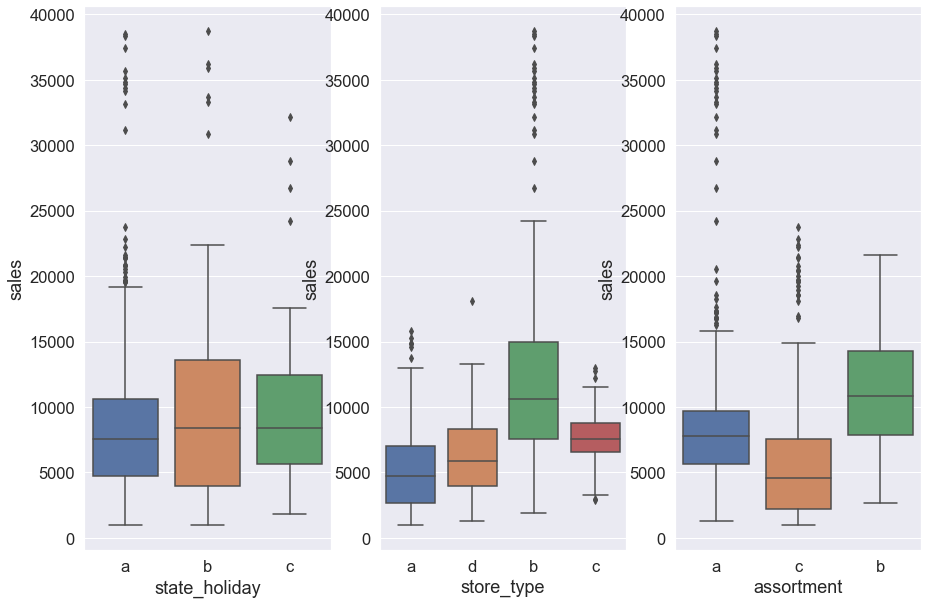

In [21]:
# filtering sales that happened during a state holiday
aux1 = df1[(df1['state_holiday']!='0') & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1);

# FEATURE ENGINEERING

In [22]:
df2=df1.copy()

## Mind Map Hypothesis 

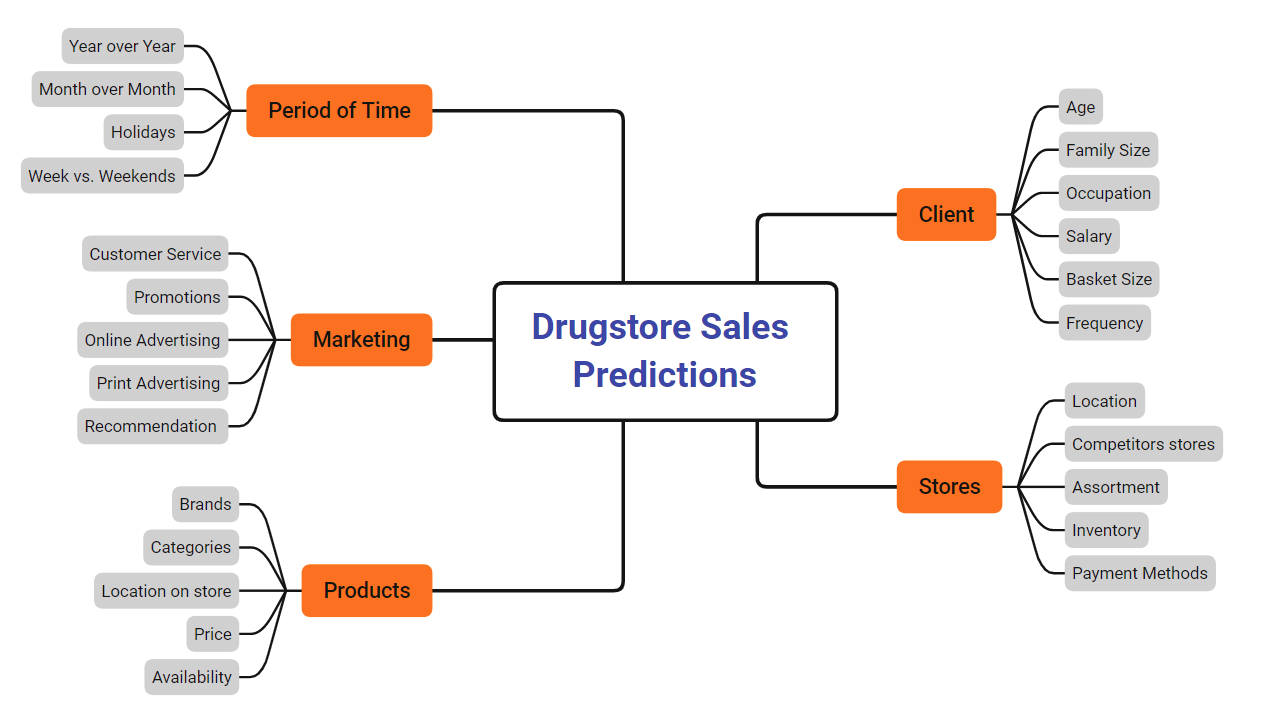

In [23]:
# importing hipothesis mind map
Image('../image/MindMapHypothesis.png')

## Creating Hypothesis

### Store Hypothesis 
1. Stores with bigger assortment should sell more.

2. Stores with closer competitors should sell less.

3. Stores with longer competitors should sell more. 

### Product Hypothesis
4. Stores with longer active promotions should sell more.

5. Stores with more consecutive promotions should sell more.

### Periodicity Hypothesis
6. Stores sell more during the Christmas holiday than during other holidays.

8. Stores should sell more over the years.

9. Stores should sell more in the second semester.

10. Stores should sell more after the 10th of each month.

11. Stores should sell less on weekends.

12. Stores should sell less during school holidays.

## Feature Engineering

In [24]:
df2 = df1.copy()
df2.head()

store  day_of_week       date  sales  customers  open  promo state_holiday  \
0      1            5 2015-07-31   5263        555     1      1             0   
1      2            5 2015-07-31   6064        625     1      1             0   
2      3            5 2015-07-31   8314        821     1      1             0   
3      4            5 2015-07-31  13995       1498     1      1             0   
4      5            5 2015-07-31   4822        559     1      1             0   

   school_holiday store_type assortment  competition_distance  \
0               1          c          a               1270.00   
1               1          a          a                570.00   
2               1          a          a              14130.00   
3               1          c          c                620.00   
4               1          a          a              29910.00   

   competition_open_since_month  competition_open_since_year  promo2  \
0                             9                         2008       0   
1                            11                         2007       1   
2                            12                         2006       1   
3                             9                         2009       0   
4                             4                         2015       0   

   promo2_since_week  promo2_since_year   promo_interval month_map  is_promo  
0                 31               2015                0       Jul         0  
1                 13               2010  Jan,Apr,Jul,Oct       Jul         1  
2                 14               2011  Jan,Apr,Jul,Oct       Jul         1  
3                 31               2015                0       Jul         0  
4                 31               2015                0       Jul         0

In [25]:
# creating 'year' from 'date'
df2['year'] = df2['date'].dt.year

# creating 'month' from 'date'
df2['month'] = df2['date'].dt.month

# creating 'day' from 'date'
df2['day'] = df2['date'].dt.day

# creating 'week_of_year' from 'date'
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

# creating 'year_week' from 'date'
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [26]:
print(df2[['date','year','month','day','week_of_year','year_week']].dtypes)
df2[['date','year','month','day','week_of_year','year_week']].head()

date            datetime64[ns]
year                     int64
month                    int64
day                      int64
week_of_year             int64
year_week               object
dtype: object


date  year  month  day  week_of_year year_week
0 2015-07-31  2015      7   31            31   2015-30
1 2015-07-31  2015      7   31            31   2015-30
2 2015-07-31  2015      7   31            31   2015-30
3 2015-07-31  2015      7   31            31   2015-30
4 2015-07-31  2015      7   31            31   2015-30

In [27]:
# creating 'competition_open_since' by combining 'competition_open_since_year and 'competition_open_since_month'
df2['competition_open_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

# creating 'competition_open_timeinmonths' by calculating the difference between 'date' and 'competition_open_since':
df2['competition_open_timeinmonths'] = ((df2['date']-df2['competition_open_since'])/30).apply(lambda x: x.days).astype('int64')

In [28]:
print(df2[['date','competition_open_since_year','competition_open_since_month',
           'competition_open_since','competition_open_timeinmonths']].dtypes)

df2[['date','competition_open_since_year','competition_open_since_month',
     'competition_open_since','competition_open_timeinmonths']].head()

date                             datetime64[ns]
competition_open_since_year               int64
competition_open_since_month              int64
competition_open_since           datetime64[ns]
competition_open_timeinmonths             int64
dtype: object


date  competition_open_since_year  competition_open_since_month  \
0 2015-07-31                         2008                             9   
1 2015-07-31                         2007                            11   
2 2015-07-31                         2006                            12   
3 2015-07-31                         2009                             9   
4 2015-07-31                         2015                             4   

  competition_open_since  competition_open_timeinmonths  
0             2008-09-01                             84  
1             2007-11-01                             94  
2             2006-12-01                            105  
3             2009-09-01                             71  
4             2015-04-01                              4

In [29]:
# creating 'promo_since' by combining 'promo2_since_year' and 'promo2_since_week'
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) # string type (year-week, ex: 2015-31)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))  # date type (yyyy-mm-dd)

# creating 'promo_since_timeinweeks' by calculating the difference between 'date' and 'promo_since':
df2['promo_since_timeinweeks'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype(np.int64)

In [30]:
print(df2[['date','promo2_since_year','promo2_since_week','promo_since','promo_since_timeinweeks']].dtypes)

df2[['date','promo2_since_year','promo2_since_week','promo_since','promo_since_timeinweeks']].head()

date                       datetime64[ns]
promo2_since_year                   int64
promo2_since_week                   int64
promo_since                datetime64[ns]
promo_since_timeinweeks             int64
dtype: object


date  promo2_since_year  promo2_since_week promo_since  \
0 2015-07-31               2015                 31  2015-07-27   
1 2015-07-31               2010                 13  2010-03-22   
2 2015-07-31               2011                 14  2011-03-28   
3 2015-07-31               2015                 31  2015-07-27   
4 2015-07-31               2015                 31  2015-07-27   

   promo_since_timeinweeks  
0                        0  
1                      279  
2                      226  
3                        0  
4                        0

In [31]:
# changing 'assortment' attribute by given classification
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' 
                                                 else 'extra' if x=='b' 
                                                 else 'extended')

In [32]:
print(df2[['assortment']].dtypes)

df2[['assortment']].head()

assortment    object
dtype: object


assortment
0      basic
1      basic
2      basic
3   extended
4      basic

In [33]:
# changing 'sate_holiday' attribute by given classification
df2['state_holiday'] = df2['state_holiday'].apply (lambda x: 'Public holiday' if x=='a' 
                                                        else 'Easter holiday' if x=='b' 
                                                        else 'Christmas'      if x=='c'
                                                        else 'regular day')

In [34]:
print(df2[['state_holiday']].dtypes)

df2[['state_holiday']].head()

state_holiday    object
dtype: object


state_holiday
0   regular day
1   regular day
2   regular day
3   regular day
4   regular day

# VARIABLE FILTERING

In [35]:
df3=df2.copy()

## Lines Filtering

In [36]:
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]

## Columns Selections

In [37]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

In [38]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_open_since',
       'competition_open_timeinmonths', 'promo_since',
       'promo_since_timeinweeks'],
      dtype='object')

# EDA

In [39]:
df4=df3[df3['date']<'2015-01-01'].copy() # filtering year for better analysis

In [40]:
num_df4 = df4.select_dtypes(include=['int64','float64'])
cat_df4 = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## Univariate Analysis

### Response Variable

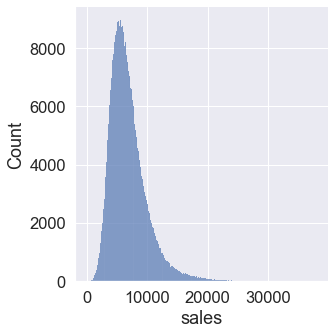

In [43]:
sns.displot(df4['sales'], legend=True, kde=False);

### Numerical Variables

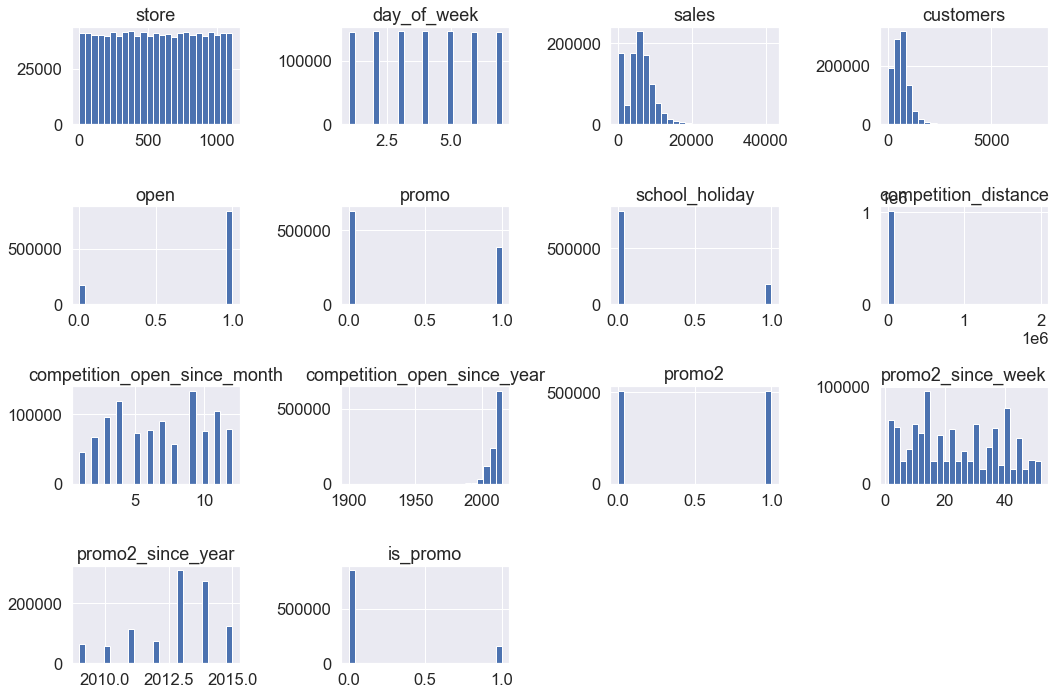

In [44]:
num_df1.hist(bins=25);
plt.tight_layout()

### Categorical Variables

In [45]:
cat_df1.head()

state_holiday store_type assortment   promo_interval month_map
0             0          c          a                0       Jul
1             0          a          a  Jan,Apr,Jul,Oct       Jul
2             0          a          a  Jan,Apr,Jul,Oct       Jul
3             0          c          c                0       Jul
4             0          a          a                0       Jul

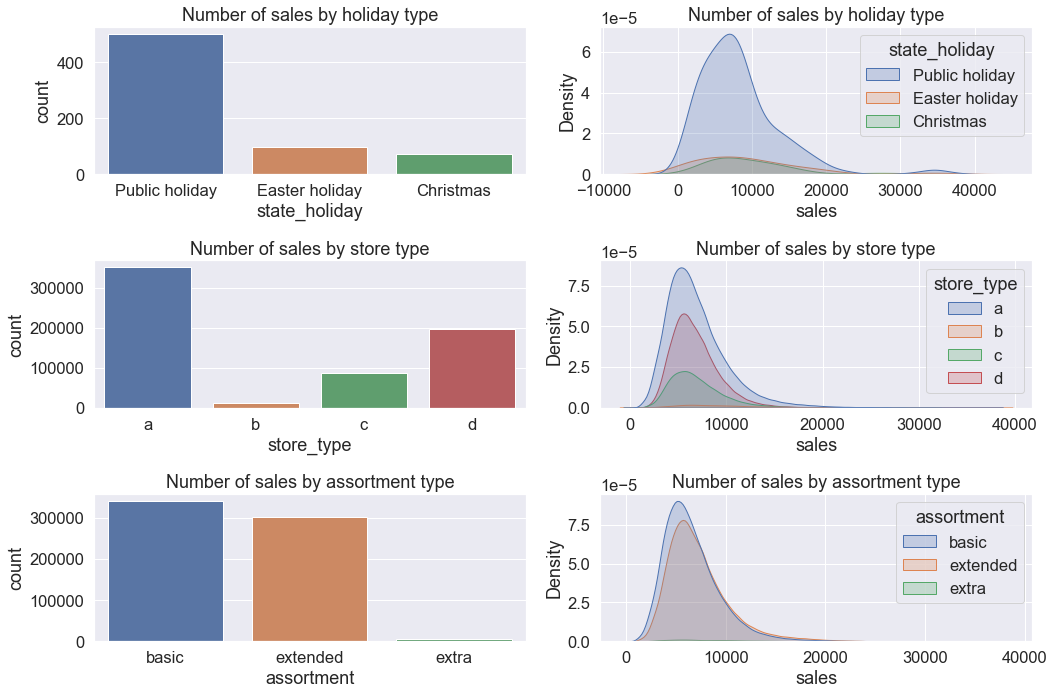

In [46]:
# sales by 'state_holiday'
a = df4[df4['state_holiday']!='regular day']
plt.subplot(3,2,1)
sns.countplot(data=a, x=a["state_holiday"], order=['Public holiday', 'Easter holiday', 'Christmas']).set_title("Number of sales by holiday type")

plt.subplot(3,2,2)
sns.kdeplot(data=a, x='sales', hue='state_holiday', hue_order=['Public holiday', 'Easter holiday', 'Christmas'], fill=True).set_title("Number of sales by holiday type");


# sales by 'store_type'
plt.subplot(3,2,3)
sns.countplot(data=df4, x=df4['store_type'], order=['a', 'b', 'c', 'd']).set_title("Number of sales by store type")

plt.subplot(3,2,4)
sns.kdeplot(data=df4, x="sales", hue="store_type", hue_order=['a', 'b', 'c', 'd'], fill=True).set_title("Number of sales by store type")


# sales by 'assortment'
plt.subplot(3,2,5)
sns.countplot(data=df4, x=df4['assortment'], order=['basic', 'extended', 'extra']).set_title("Number of sales by assortment type");

plt.subplot(3,2,6)
sns.kdeplot(data=df4, x="sales", hue="assortment", hue_order=['basic', 'extended', 'extra'], fill=True).set_title("Number of sales by assortment type");

plt.tight_layout()

## Bivariate Analysis

Hypothesis Resume

In [47]:
tab = [ ['Hypothesis', 'Conclusion', 'Relevance', 'Conclusion'],
        ['H1','True', 'Low',  'Stores with bigger assortment sell more on average.'],
        ['H2','False','High', 'Stores with closer competitors sell more.'],
        ['H3','False','Low',  'Stores with longer competitors should sell less.'],
        ['H4','False','High', 'Stores with longer active promotions sell less after a certain period of time'],
        ['H5','False','High', 'Stores with more consecutive promotions sell less.'],
        ['H6','True' ,'High', 'Stores sell more during the Christmas holiday than during other holidays'],
        ['H7','False','High', 'Stores are selling less over the years.'],
        ['H8','True', 'High', 'Stores sell more in the second semester.'],
        ['H9','False','High', ' Stores sell less after the 10th of each month.'],
        ['H10','False','High', 'Stores sell more on weekends.'],
        ['H11','False','High', 'Stores sell more during school holidays.'],
        
      ]

print(tabulate(tab, headers = 'firstrow'))

Hypothesis    Conclusion    Relevance    Conclusion
------------  ------------  -----------  -----------------------------------------------------------------------------
H1            True          Low          Stores with bigger assortment sell more on average.
H2            False         High         Stores with closer competitors sell more.
H3            False         Low          Stores with longer competitors should sell less.
H4            False         High         Stores with longer active promotions sell less after a certain period of time
H5            False         High         Stores with more consecutive promotions sell less.
H6            True          High         Stores sell more during the Christmas holiday than during other holidays
H7            False         High         Stores are selling less over the years.
H8            True          High         Stores sell more in the second semester.
H9            False         High         Stores sell less after the 10th of

### Stores with bigger assortment should sell more.
**True:** Stores with bigger assortment sell more on average.

assortment     basic  extended   extra
avg_sales    6612.76   7229.01 8364.17
qty_stores 340937.00 301071.00 6301.00

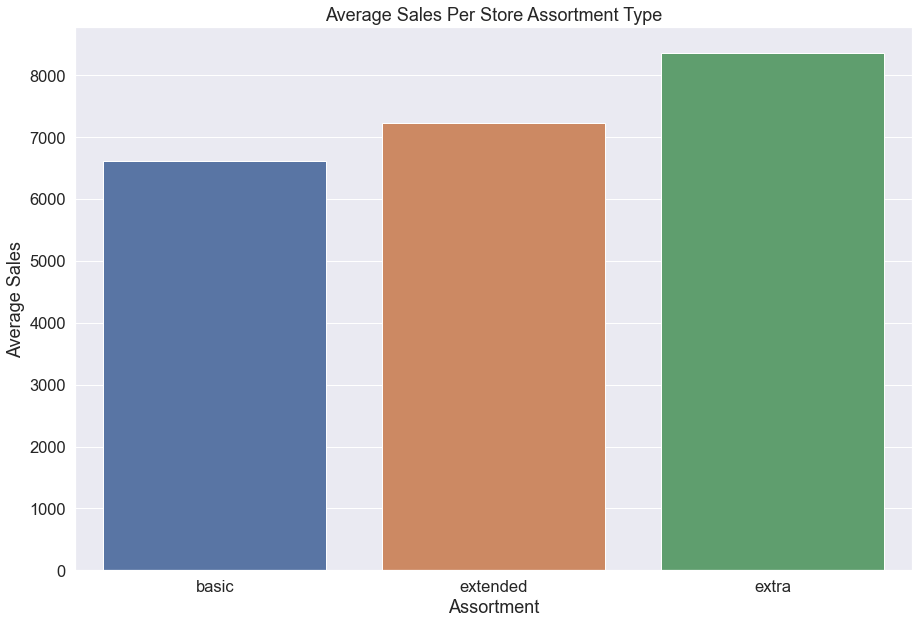

In [48]:
# checking 'sales' by 'assortoment'
a = df4[['store','assortment', 'sales']].copy()

b = (a.groupby('assortment').agg(qty_stores = ('store', 'count'),
                                 avg_sales  = ('sales', 'mean'))).reset_index()

c = pd.pivot_table(b, columns='assortment')
display(c)

ax = sns.barplot(data=b, x='assortment', y='avg_sales');
ax.set(xlabel="Assortment", ylabel="Average Sales", title="Average Sales Per Store Assortment Type");

### Stores with closer competitors should sell less.
**False:** Stores with closer competitors sell more.

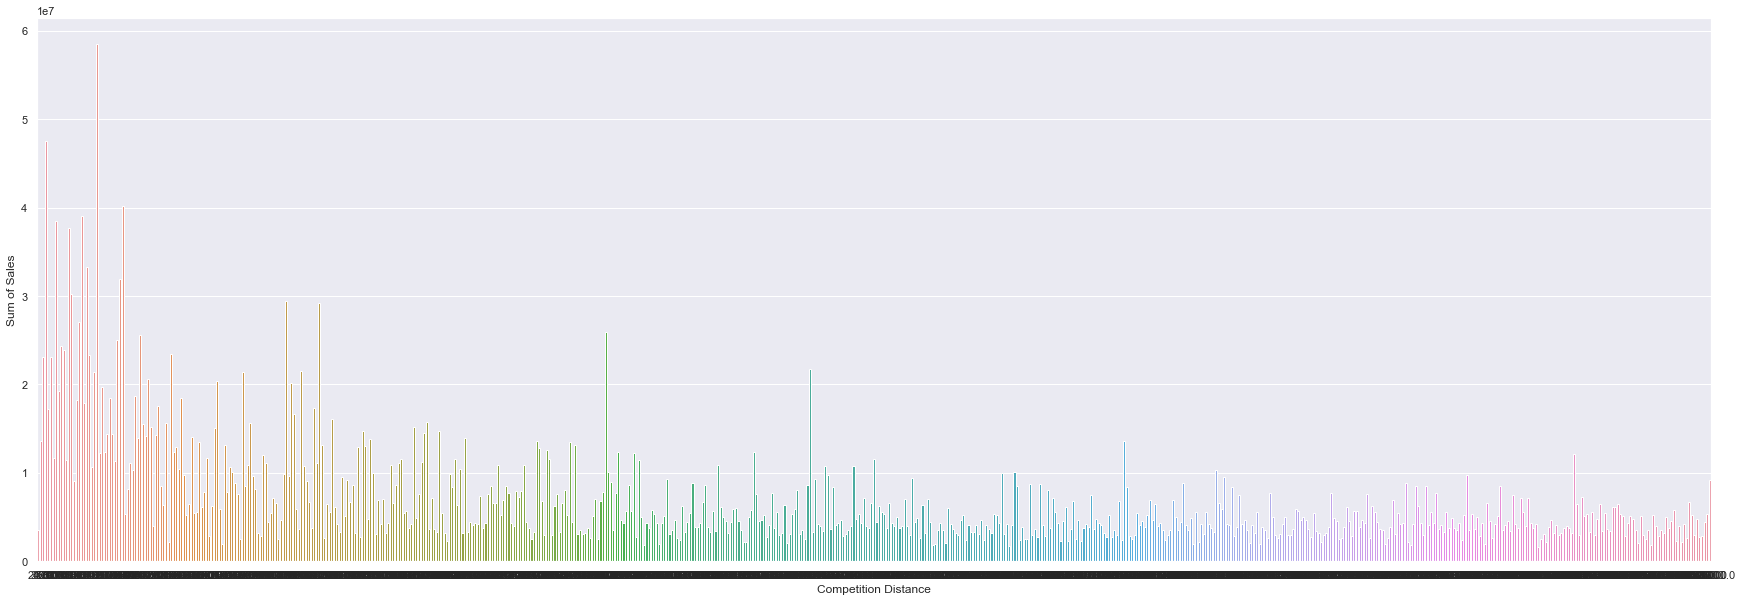

In [49]:
# checking sales by 'competition_distance'
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.set(rc={'figure.figsize':(30,10)})
sns.barplot(data = aux1, x='competition_distance', y='sales').set(xlabel='Competition Distance', ylabel='Sum of Sales');
personal_settings();

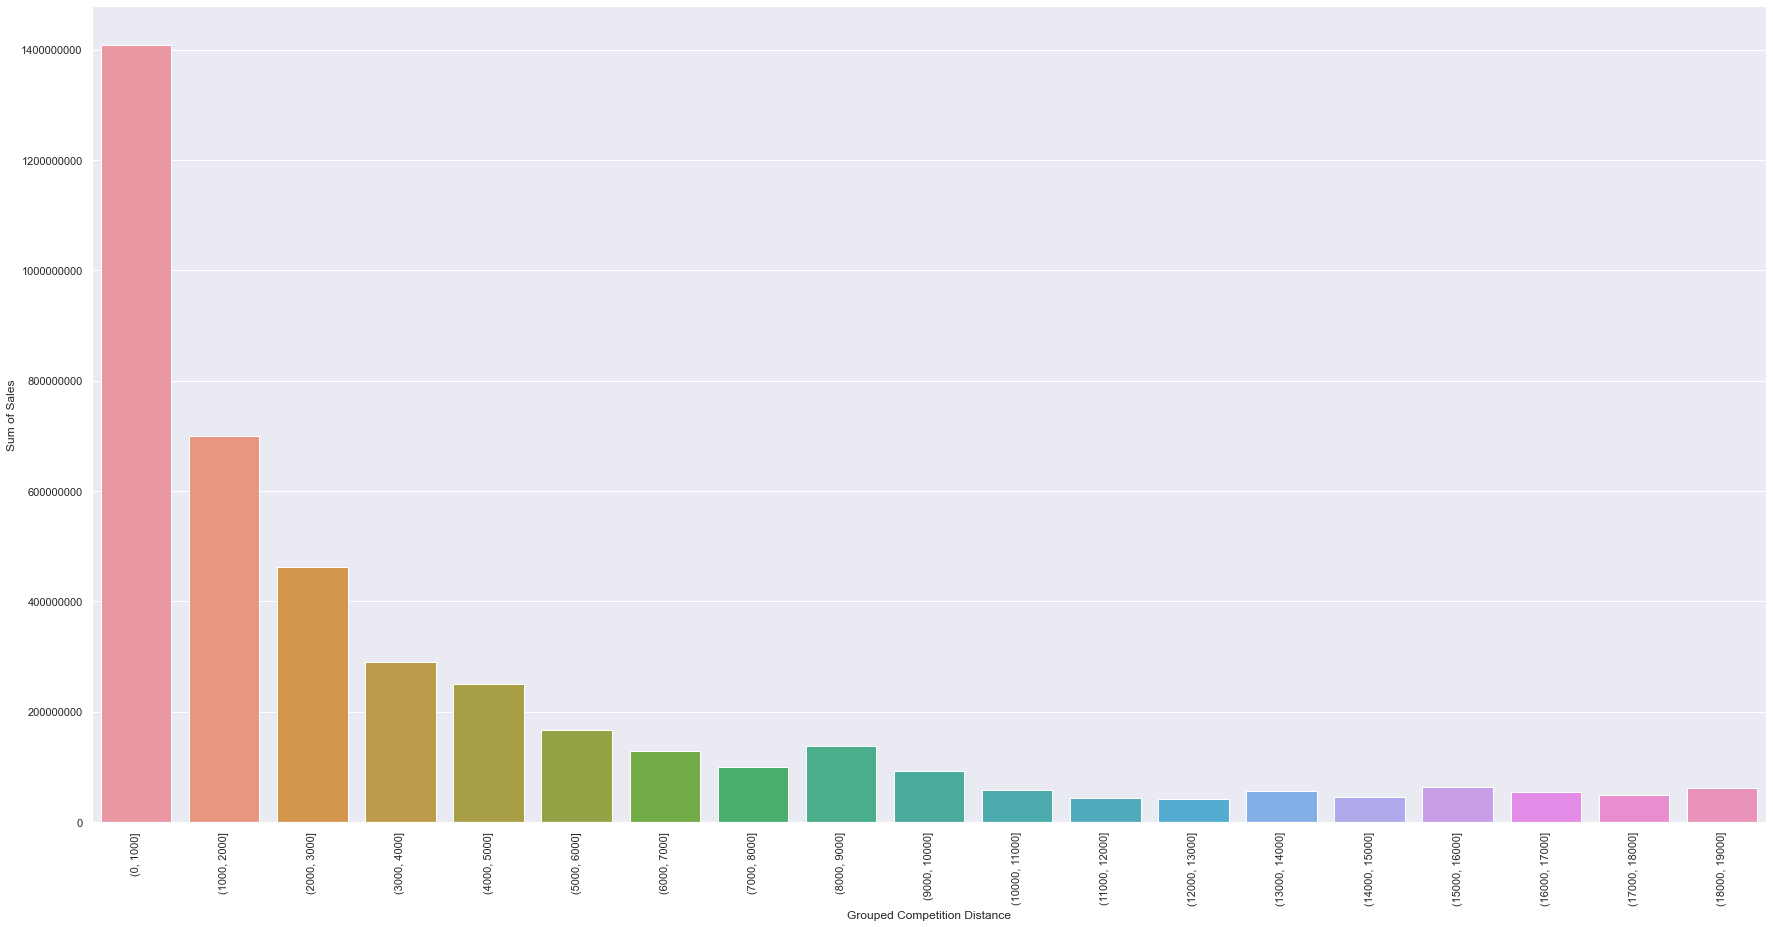

In [50]:
# grouping 'competition_distance' in bins
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bingroup = list (np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bingroup)

aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
#display(aux2.head())
sns.set(rc={'figure.figsize':(30,15)})
sns.barplot(data=aux2, x='competition_distance_binned', y='sales').set(xlabel='Grouped Competition Distance', ylabel='Sum of Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90);
personal_settings();

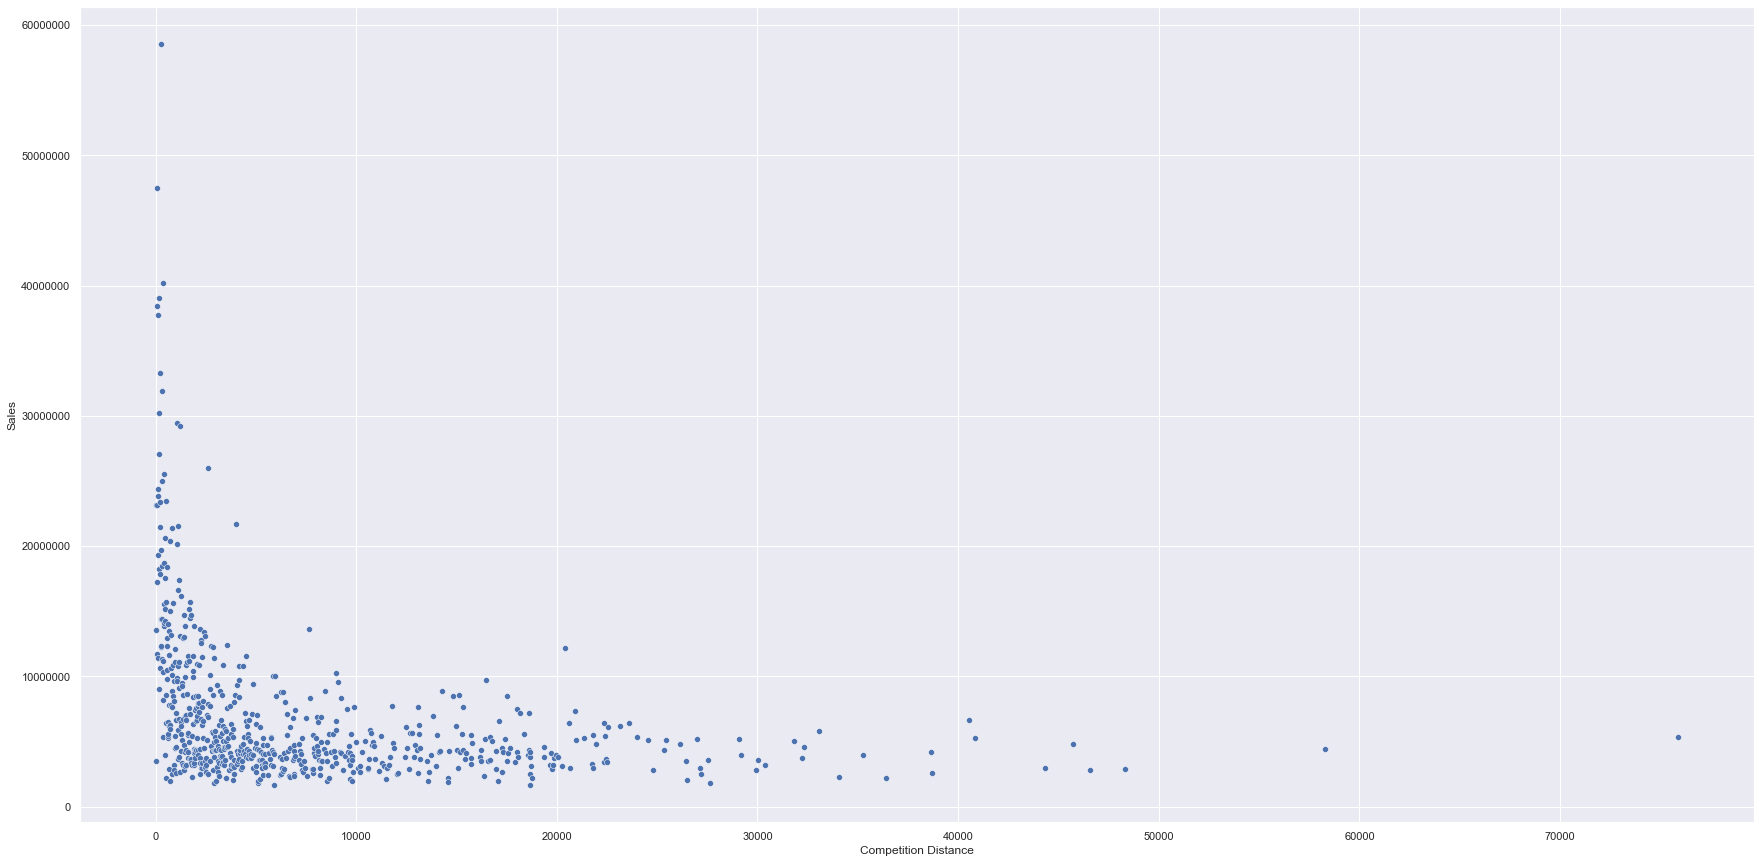

In [51]:
# checking 'competition_distance' distribution
aux1 = df4[df4['competition_distance']!=2000000][['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

sns.set(rc={'figure.figsize':(30,15)})
sns.scatterplot(data=aux1, x='competition_distance', y='sales').set(xlabel='Competition Distance', ylabel='Sales');
plt.ticklabel_format(style='plain', axis='y')
personal_settings();







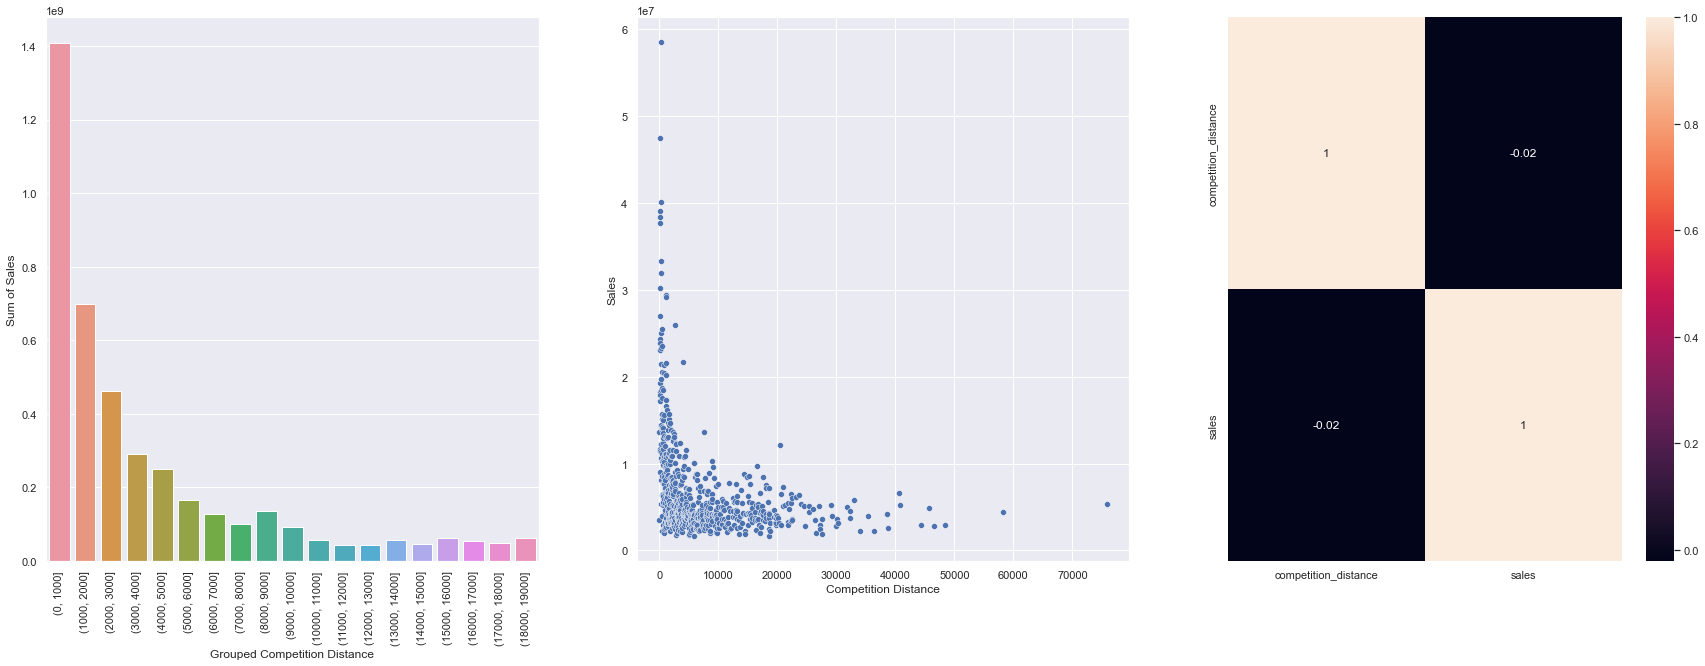

In [52]:
# comparing
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.set(rc={'figure.figsize':(30, 10)})

plt.subplot (1,3,1)
bingroup = list (np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bingroup)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales').set(xlabel='Grouped Competition Distance', ylabel='Sum of Sales')
plt.xticks(rotation=90);

plt.subplot (1,3,2)
aux2 = aux1[aux1['competition_distance']!=2000000]
sns.scatterplot(data=aux2, x='competition_distance', y='sales').set(xlabel='Competition Distance', ylabel='Sales');

plt.subplot (1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
personal_settings();

### Stores with longer competitors should sell more.
**False:** Stores with longer competitors should sell less.

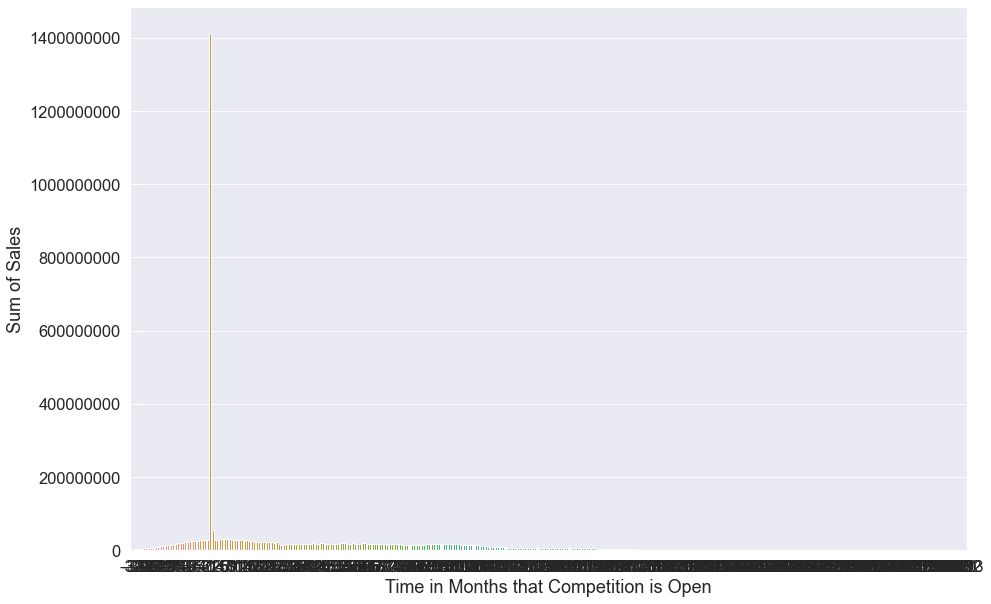

In [53]:
# checking 'sales' by 'competition_open_timeinmonths'
aux1 = df4[['competition_open_timeinmonths','sales']].groupby('competition_open_timeinmonths').sum().reset_index()
sns.barplot(data = aux1, x='competition_open_timeinmonths', y='sales').set(xlabel='Time in Months that Competition is Open', ylabel='Sum of Sales');
plt.ticklabel_format(style='plain', axis='y');

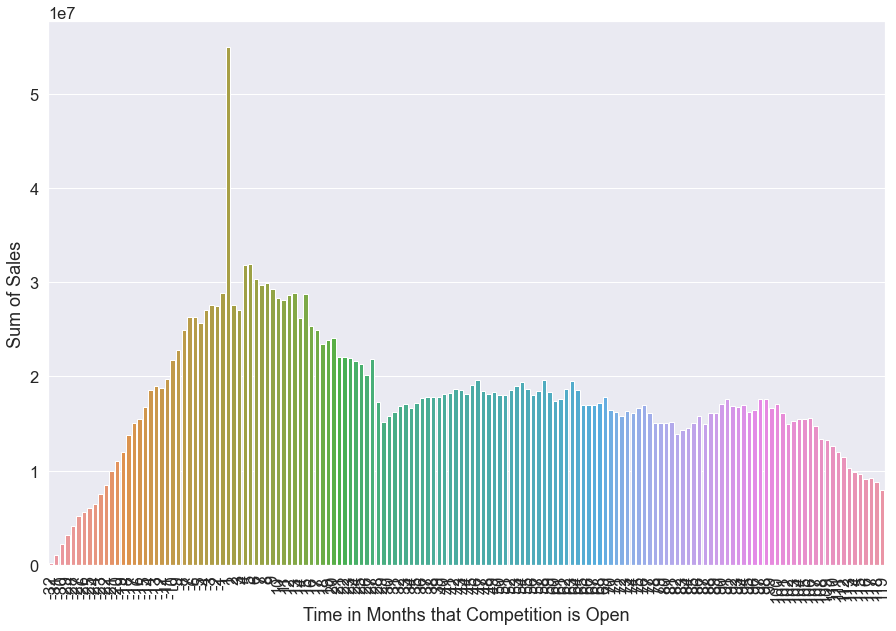

In [54]:
# checking 'competition_open_timeinmonths' for less than 120 months
aux1 = df4[['competition_open_timeinmonths','sales']].groupby('competition_open_timeinmonths').sum().reset_index()
aux2 = aux1[( aux1['competition_open_timeinmonths']<120 ) & ( aux1['competition_open_timeinmonths'] != 0)]

sns.barplot(data = aux2, x='competition_open_timeinmonths', y='sales').set(xlabel='Time in Months that Competition is Open', ylabel='Sum of Sales');
plt.xticks(rotation=90);

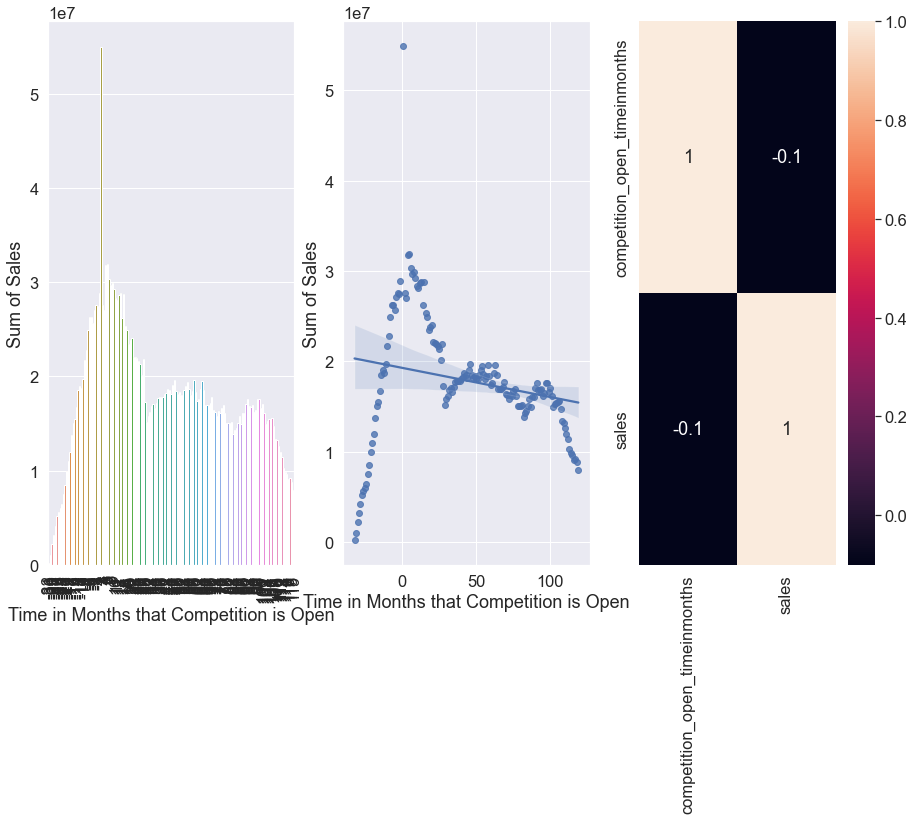

In [55]:
plt.subplot(1,3,1)
aux1 = df4[['competition_open_timeinmonths','sales']].groupby('competition_open_timeinmonths').sum().reset_index()
aux2 = aux1[( aux1['competition_open_timeinmonths']<120 ) & ( aux1['competition_open_timeinmonths']!=0)]
sns.barplot(data = aux2, x='competition_open_timeinmonths', y='sales').set(xlabel='Time in Months that Competition is Open', ylabel='Sum of Sales');
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(data = aux2, x='competition_open_timeinmonths', y='sales').set(xlabel='Time in Months that Competition is Open', ylabel='Sum of Sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### Stores with longer active promotions should sell more
**False:** Stores with longer active promotions sell less after a certain period of time.

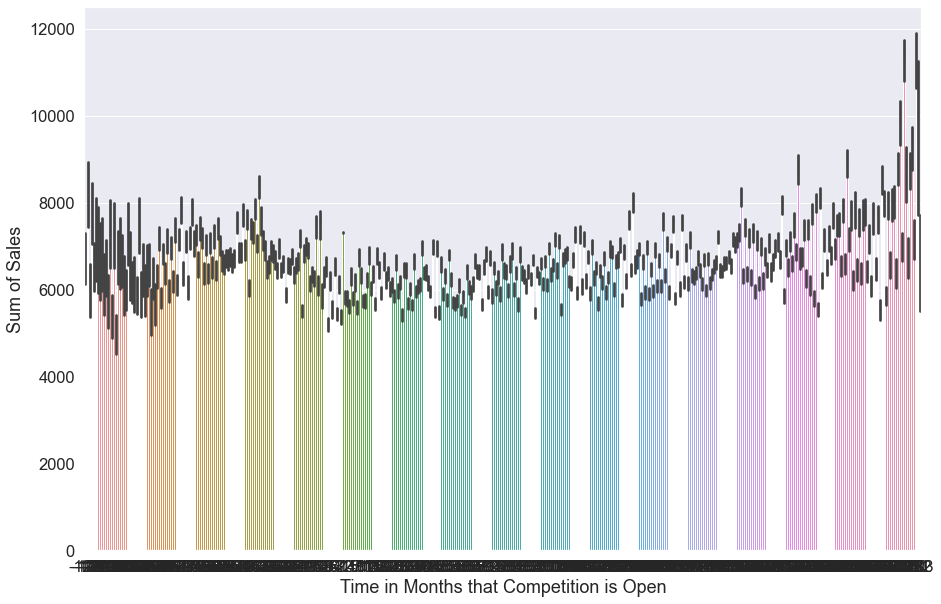

In [56]:
# checking 'sales' by 'promo_since_timeinweeks'
aux1 = df4[['promo_since_timeinweeks','sales']].groupby('promo_since_timeinweeks').sum().reset_index()
sns.barplot(data=df4, x = 'promo_since_timeinweeks', y = 'sales').set(xlabel='Time in Months that Competition is Open', ylabel='Sum of Sales');

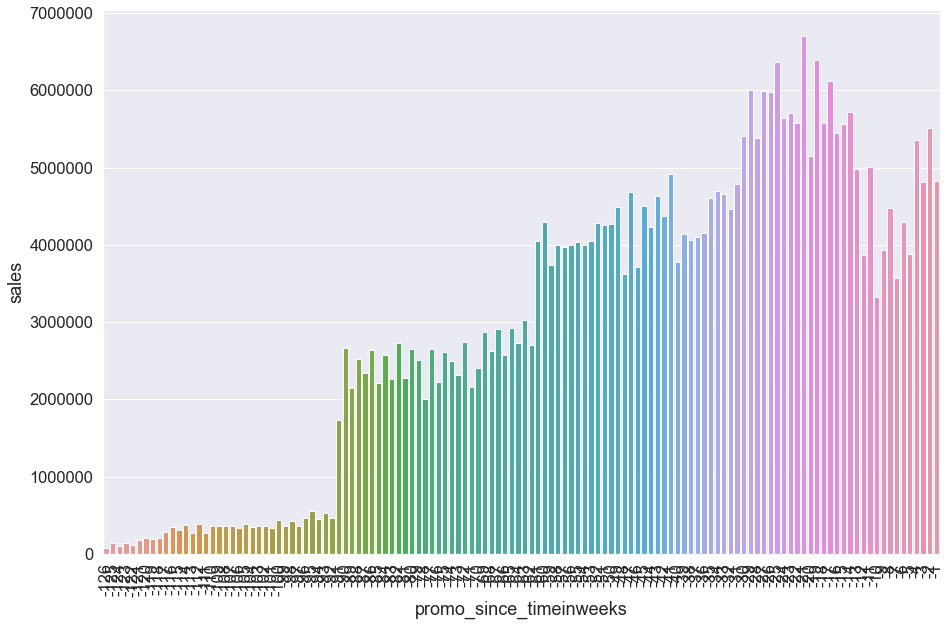

In [57]:
aux3 = aux1[aux1['promo_since_timeinweeks'] < 0] # promotions started after sales
sns.barplot(data=aux3, x='promo_since_timeinweeks', y='sales');
plt.ticklabel_format(style='plain', axis='y');
plt.xticks(rotation = 90);

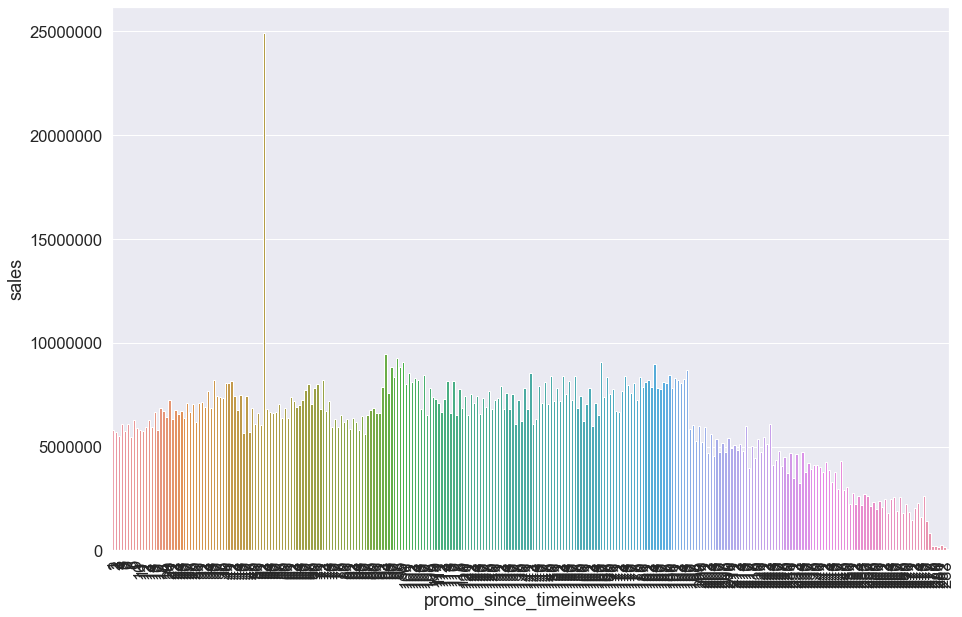

In [58]:
aux2 = aux1[aux1['promo_since_timeinweeks'] > 0] # promotions started before sales
sns.barplot(data=aux2, x='promo_since_timeinweeks', y='sales');
plt.ticklabel_format(style='plain', axis='y');
plt.xticks(rotation = 90);

### Stores with more consecutive promotions should sell more
**False:** Stores with more consecutive promotions sell less.

In [59]:
df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().sort_values('sales', ascending=True).reset_index()

promo  promo2       sales
0      0       1   987928378
1      1       1  1102311941
2      0       0  1153307565
3      1       0  1240133096

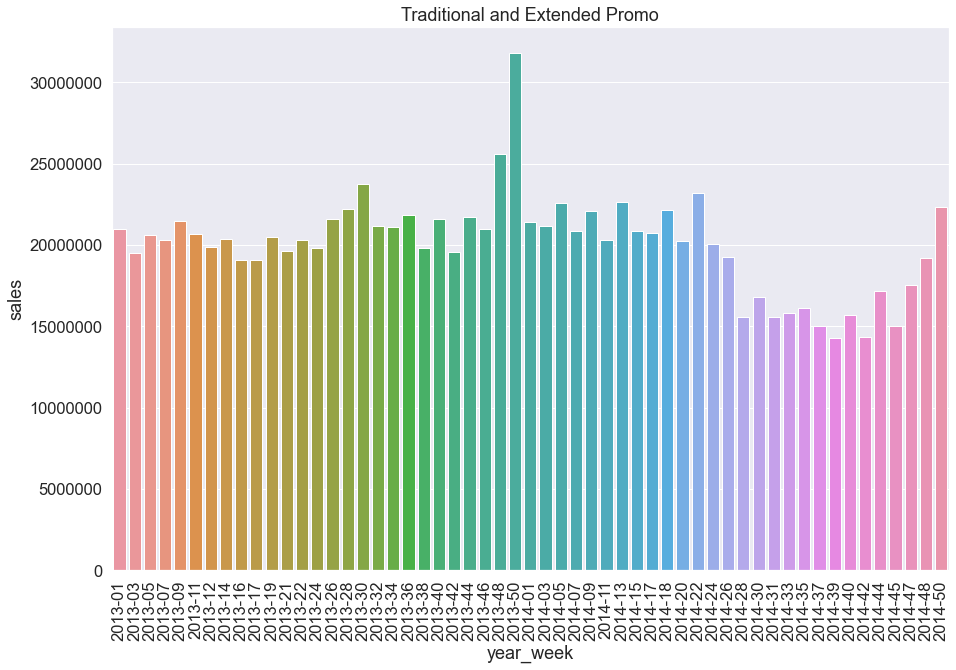

In [60]:
# stores that participated on tradicional and extended promo
aux1 = df4[(df4['promo'] ==1) & (df4['promo2'] ==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
sns.barplot(data=aux1, x ='year_week', y = 'sales');
plt.xticks(rotation = 90);
#display(aux1.head())

plt.ticklabel_format(style='plain', axis='y');
plt.xlabel('year_week');
plt.ylabel('sales');
plt.title('Traditional and Extended Promo');

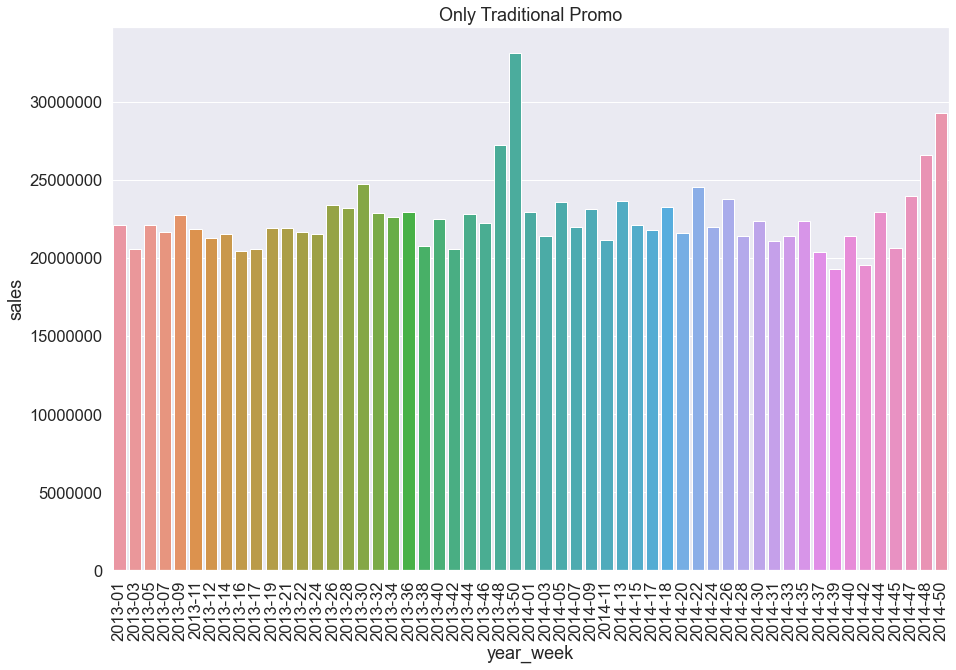

In [61]:
# stores that participated only on tradicional promo
aux2 = df4[(df4['promo'] ==1) & (df4['promo2'] ==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
sns.barplot(data=aux2, x ='year_week', y = 'sales');
plt.xticks(rotation = 90);
#display(aux2.head())

plt.ticklabel_format(style='plain', axis='y');
plt.xlabel('year_week');
plt.ylabel('sales');
plt.title('Only Traditional Promo');

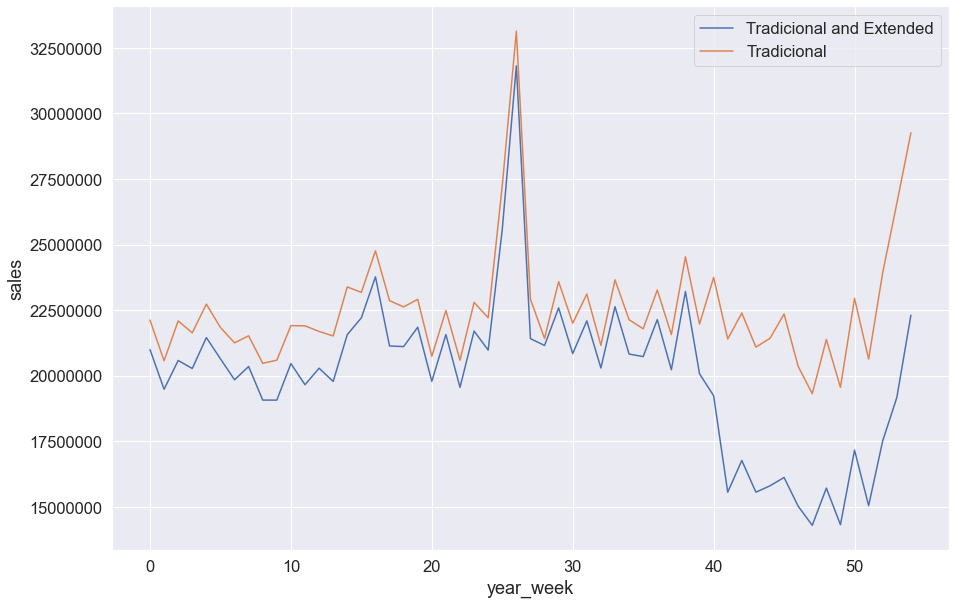

In [62]:
# stores that participated on tradicional and extended promo
aux1 = df4[(df4['promo'] ==1) & (df4['promo2'] ==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

# stores that participated only on tradicional promo
aux2 = df4[(df4['promo'] ==1) & (df4['promo2'] ==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

plt.ticklabel_format(style='plain', axis='y');
ax.legend(labels = ['Tradicional and Extended', 'Tradicional']);
plt.xlabel('year_week');
plt.ylabel('sales');

###  Stores sell more during the Christmas holiday than during other holidays
**True:** Stores sell more during the Christmas holiday than during other holidays

state_holiday   sales
0       Christmas 9743.75
1  Easter holiday 9566.15
2  Public holiday 8257.53

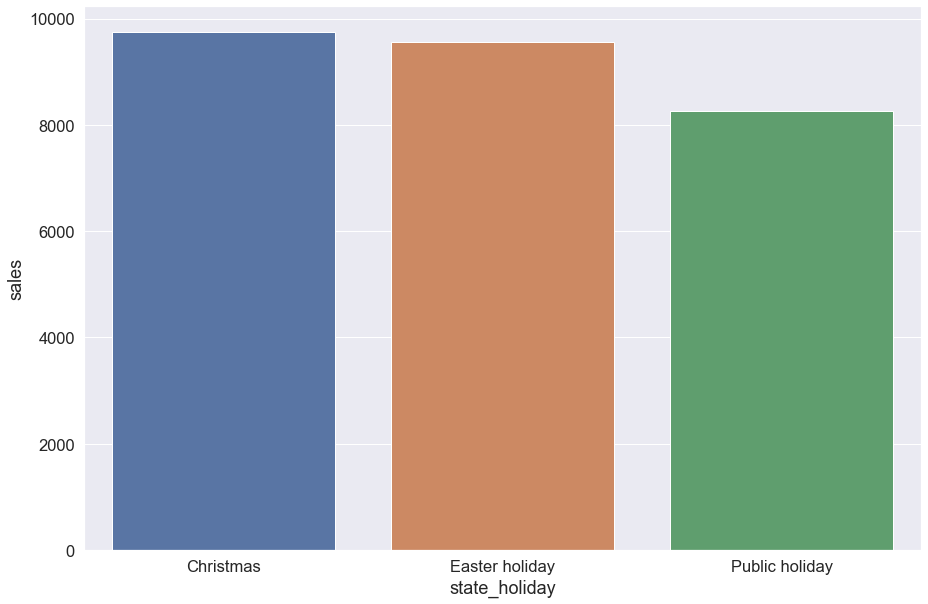

In [63]:
# checking 'sales' by 'state_holiday'
aux = df4[df4['state_holiday'] != 'regular day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(data = aux1, x = 'state_holiday', y = 'sales');

display(aux1)

### Stores should sell more over the years
**False:** Stores are selling less over the years.

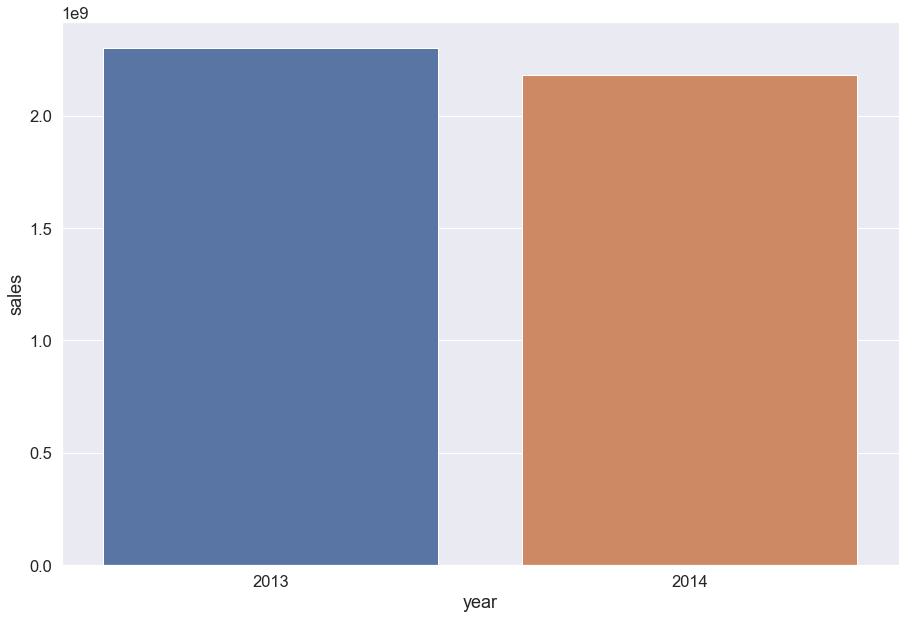

In [64]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

sns.barplot(data=aux1, x='year', y='sales');

### Stores should sell more in the second semester
**True:** Stores sell more in the second semester.

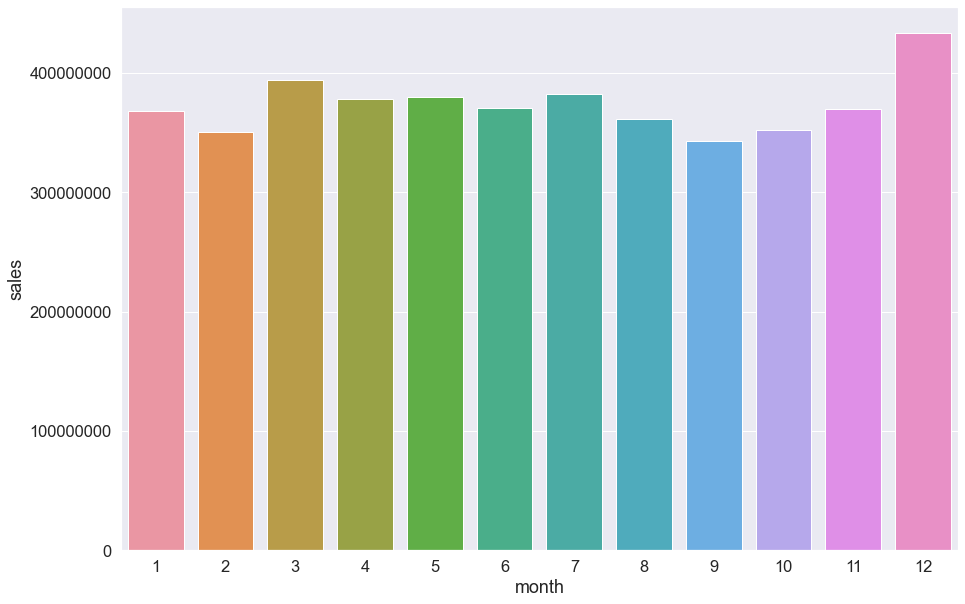

In [65]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(data = aux1, x = 'month', y = 'sales');
plt.ticklabel_format(style='plain', axis='y');

# próximo ciclo agrupar vendas de meses 1 a 6 e 7 a 12

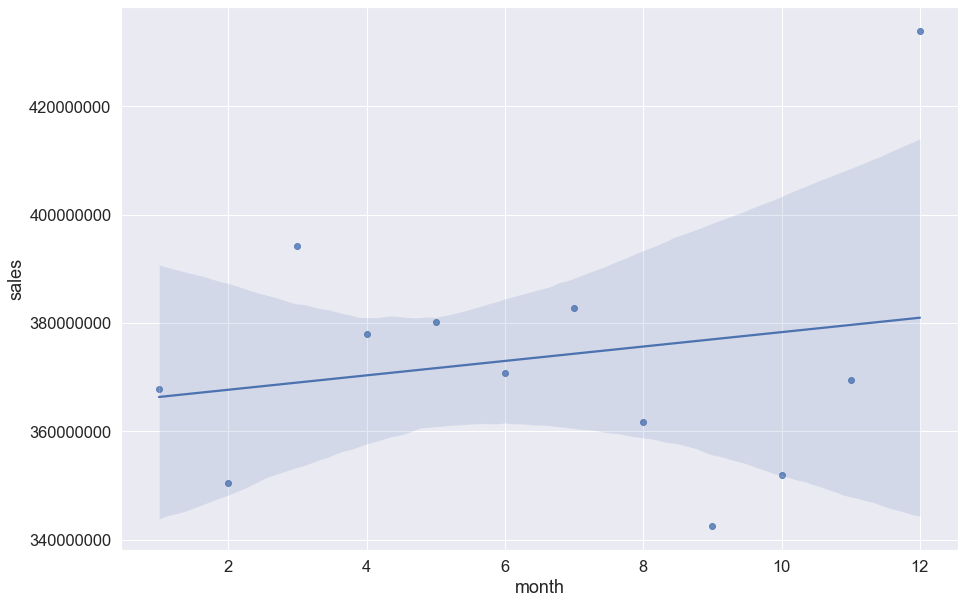

In [66]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
sns.regplot(data = aux1, x = 'month', y = 'sales');
plt.ticklabel_format(style='plain', axis='y');



month_binned       sales
1      (6, 12]  2242306680
0       (0, 6]  2241374300

Sales difference between 2nd Semester and 1st Semester: R$932,380.00


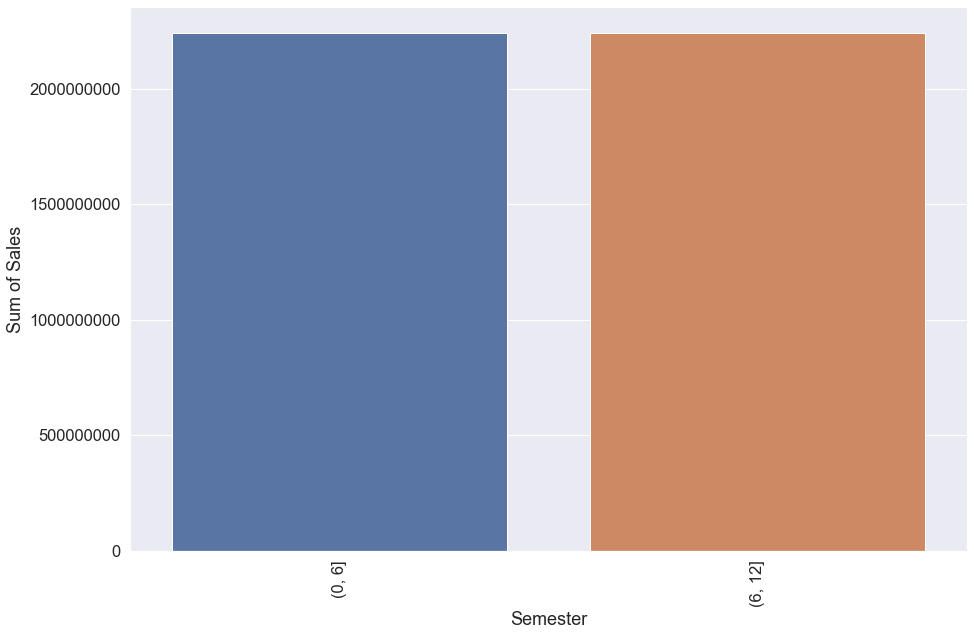

In [67]:
# grouping 'month' in bins
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
aux1

bingroup = list (np.arange(0,13,6))
aux1['month_binned'] = pd.cut(aux1['month'], bins = bingroup)
aux1

aux2 = aux1[['month_binned','sales']].groupby('month_binned').sum().reset_index()
display(aux2.sort_values('sales', ascending=False))

sns.barplot(data=aux2, x='month_binned', y='sales').set(xlabel='Semester', ylabel='Sum of Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90);

print('Sales difference between 2nd Semester and 1st Semester: R${:,.2f}'.format(aux2['sales'].max() - aux2['sales'].min()))

### Stores should sell more after the 10th of each month
**False:** Stores sell less after the 10th of each month.

before_after10   sales
1   before_day10 7276.14
0    after_day10 6771.38

Sales difference between before and after 10th of each month: R$504.77


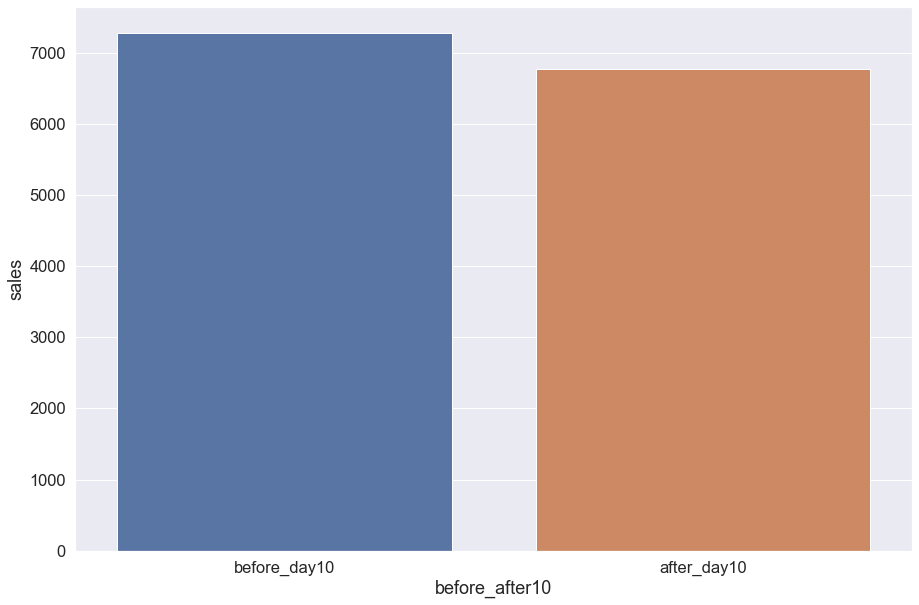

In [68]:
aux1 = df4[['day','sales']].groupby('day').mean().reset_index()
aux1['before_after10'] = aux1['day'].apply (lambda x: 'before_day10' if x <= 10 else 'after_day10')
aux1

aux2 = aux1[['before_after10','sales']].groupby('before_after10').mean().reset_index()
display(aux2.sort_values('before_after10', ascending=False))
sns.barplot(data=aux2, x='before_after10', y='sales', order=['before_day10', 'after_day10']);

print('Sales difference between before and after 10th of each month: R${:,.2f}'.format(aux2['sales'][1] - aux2['sales'][0]))

# próximo ciclo: calcular média de vendas por dia nos dez primeiros dias, e depois a média de vendas nos demais vinte dias, ou fazer três grupos de 10 dias cada.

### Stores should sell less on weekends
**False:** Stores sell more on weekends.

Average sales during the week:  R$7,135.22
Average sales during the weekend:  R$8,084.93

Sales difference between weekend and week days: R$949.71


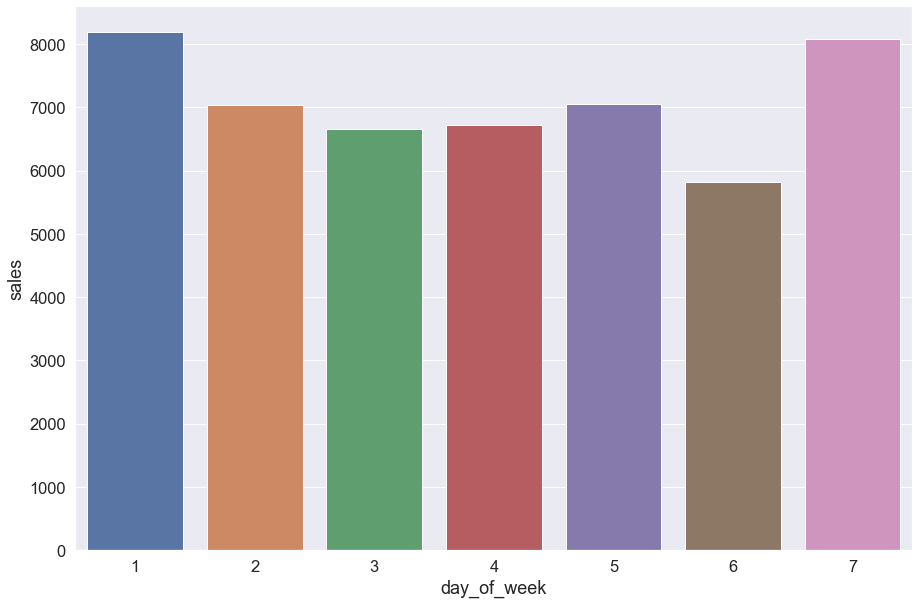

In [69]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').mean().reset_index()

sns.barplot(data=aux1, x='day_of_week', y='sales');
plt.ticklabel_format(style='plain', axis='y');

avg_weekday = aux1[aux1['day_of_week']<6]['sales'].mean()
avg_weekend = aux1[aux1['day_of_week']>6]['sales'].mean()

print('Average sales during the week:  R${:,.2f}'.format(avg_weekday))
print('Average sales during the weekend:  R${:,.2f}'.format(avg_weekend))
print('\nSales difference between weekend and week days: R${:,.2f}'.format(avg_weekend - avg_weekday))

# próximo ciclo: avaliar a frequência que as lojas ficam abertas aos fins de semana.

### Stores should sell less during school holidays
**False:** Stores sell more during school holidays.

school_holiday   sales
0               0 6875.13
1               1 7075.88

Sales difference between other days and school holidays: R$364.29


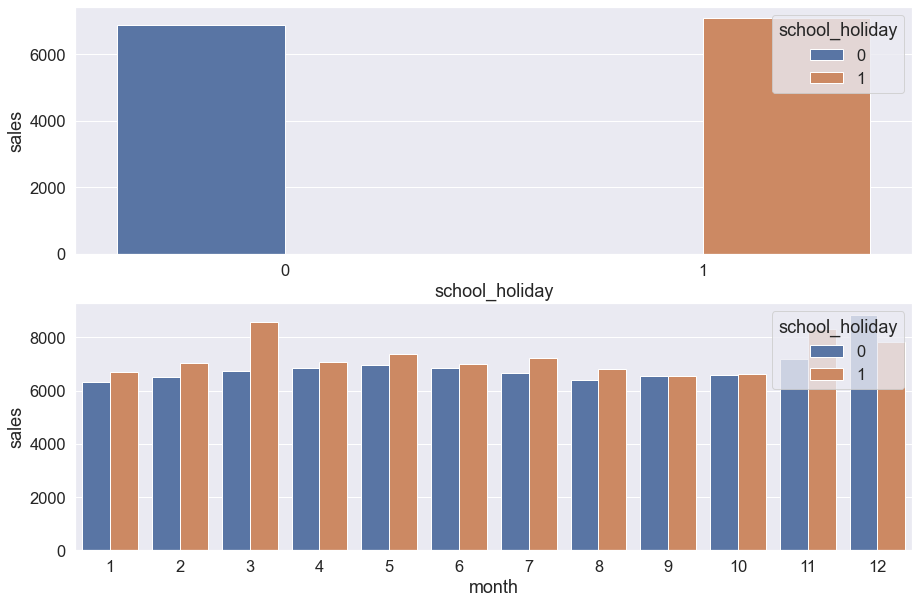

In [70]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()
display(aux1)

plt.subplot(2,1,1)
sns.barplot(data=aux1, x='school_holiday', y='sales', hue='school_holiday')

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).mean().reset_index()
sns.barplot(data= aux2, x='month', y='sales', hue='school_holiday');

print('Sales difference between other days and school holidays: R${:,.2f}'.format(aux2['sales'][1] - aux2['sales'][0]))


# próximo ciclo: fazer média de vendas em dias comuns vs. média de vendas em dias de feriados escolares.

## Multivariate Analysis

### Numerical Attributes

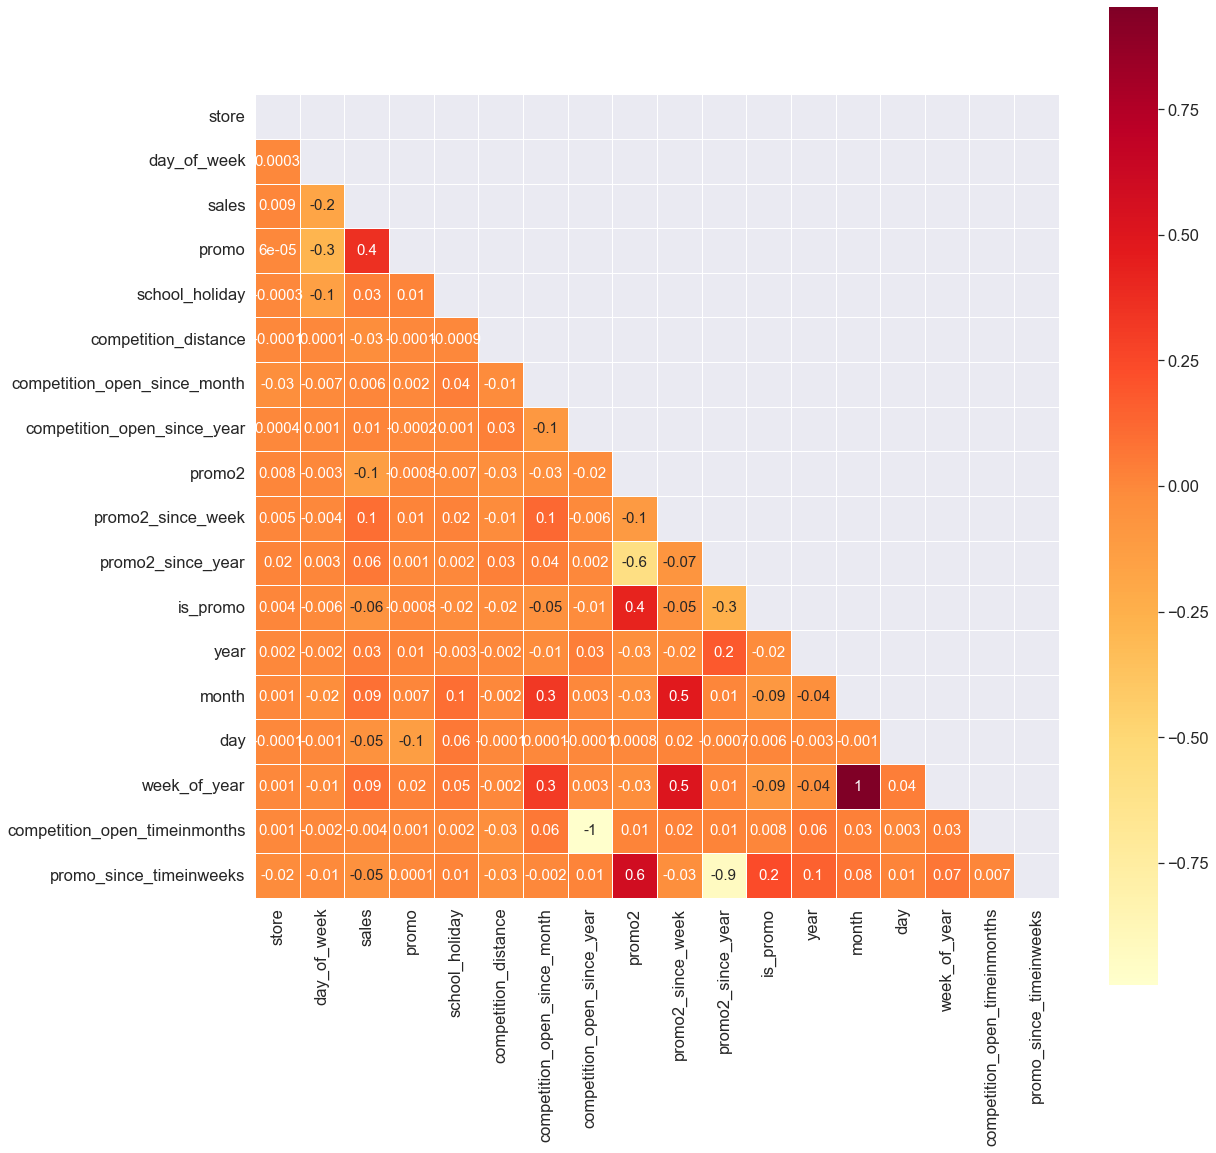

In [71]:
correlation = num_df4.corr(method = 'pearson')

corr_mask = np.triu(correlation)

plt.figure(figsize=(18,18))
sns.heatmap(correlation, 
            cmap='YlOrRd', 
            annot=True, 
            annot_kws={'fontsize':'small'},
            fmt='.1g',
            linewidths=0.8, 
            square=True,
            mask=corr_mask);

### Categorical Attributes

In [72]:
df4.dtypes

store                                     int64
day_of_week                               int64
date                             datetime64[ns]
sales                                     int64
promo                                     int64
state_holiday                            object
school_holiday                            int64
store_type                               object
assortment                               object
competition_distance                    float64
competition_open_since_month              int64
competition_open_since_year               int64
promo2                                    int64
promo2_since_week                         int64
promo2_since_year                         int64
is_promo                                  int64
year                                      int64
month                                     int64
day                                       int64
week_of_year                              int64
year_week                               

               state_holiday  store_type  assortment
state_holiday           1.00        0.07        0.07
store_type              0.07        1.00        0.54
assortment              0.07        0.54        1.00 



<AxesSubplot:>

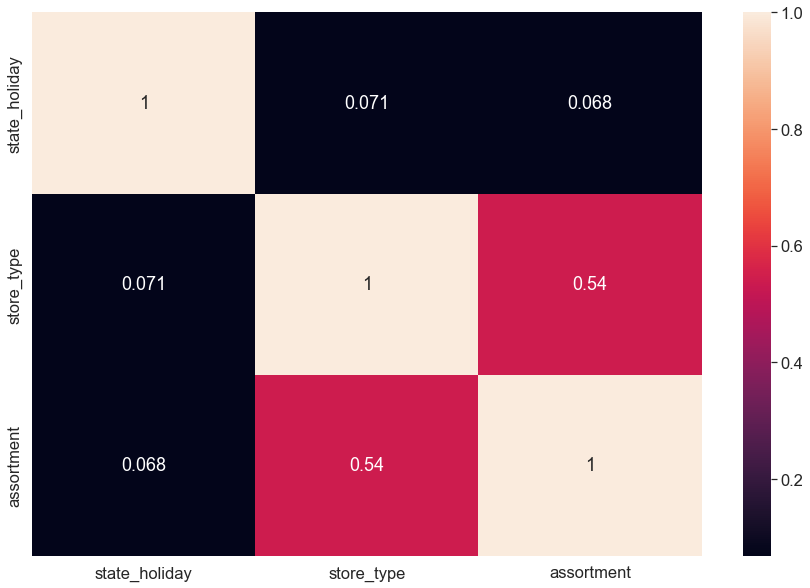

In [73]:
# calculating Cramer V (formula at Helper Function section)

a1 = cramer_v(cat_df4['state_holiday'], cat_df4['state_holiday'])
a2 = cramer_v(cat_df4['state_holiday'], cat_df4['store_type'])
a3 = cramer_v(cat_df4['state_holiday'], cat_df4['assortment'])

a4 = cramer_v(cat_df4['store_type'], cat_df4['state_holiday'])
a5 = cramer_v(cat_df4['store_type'], cat_df4['store_type'])
a6 = cramer_v(cat_df4['store_type'], cat_df4['assortment'])

a7 = cramer_v(cat_df4['assortment'], cat_df4['state_holiday'])
a8 = cramer_v(cat_df4['assortment'], cat_df4['store_type'])
a9 = cramer_v(cat_df4['assortment'], cat_df4['assortment'])

# final dataset 
t = pd.DataFrame({'state_holiday': [ a1,a2,a3],
                  'store_type':    [ a4,a5,a6],
                  'assortment':    [ a7,a8,a9]})

t = t.set_index(t.columns)
print (t, '\n')

sns.heatmap (data=t, annot=True)

# DATA PREPARATION

In [41]:
df5=df3.copy() # copying from df3 with full date range

## Rescaling

In [42]:
num_df5 = df5.select_dtypes(include=['int64','float64'])
num_df5.head()

store  day_of_week  sales  promo  school_holiday  competition_distance  \
0      1            5   5263      1               1               1270.00   
1      2            5   6064      1               1                570.00   
2      3            5   8314      1               1              14130.00   
3      4            5  13995      1               1                620.00   
4      5            5   4822      1               1              29910.00   

   competition_open_since_month  competition_open_since_year  promo2  \
0                             9                         2008       0   
1                            11                         2007       1   
2                            12                         2006       1   
3                             9                         2009       0   
4                             4                         2015       0   

   promo2_since_week  promo2_since_year  is_promo  year  month  day  \
0                 31               2015         0  2015      7   31   
1                 13               2010         1  2015      7   31   
2                 14               2011         1  2015      7   31   
3                 31               2015         0  2015      7   31   
4                 31               2015         0  2015      7   31   

   week_of_year  competition_open_timeinmonths  promo_since_timeinweeks  
0            31                             84                        0  
1            31                             94                      279  
2            31                            105                      226  
3            31                             71                        0  
4            31                              4                        0

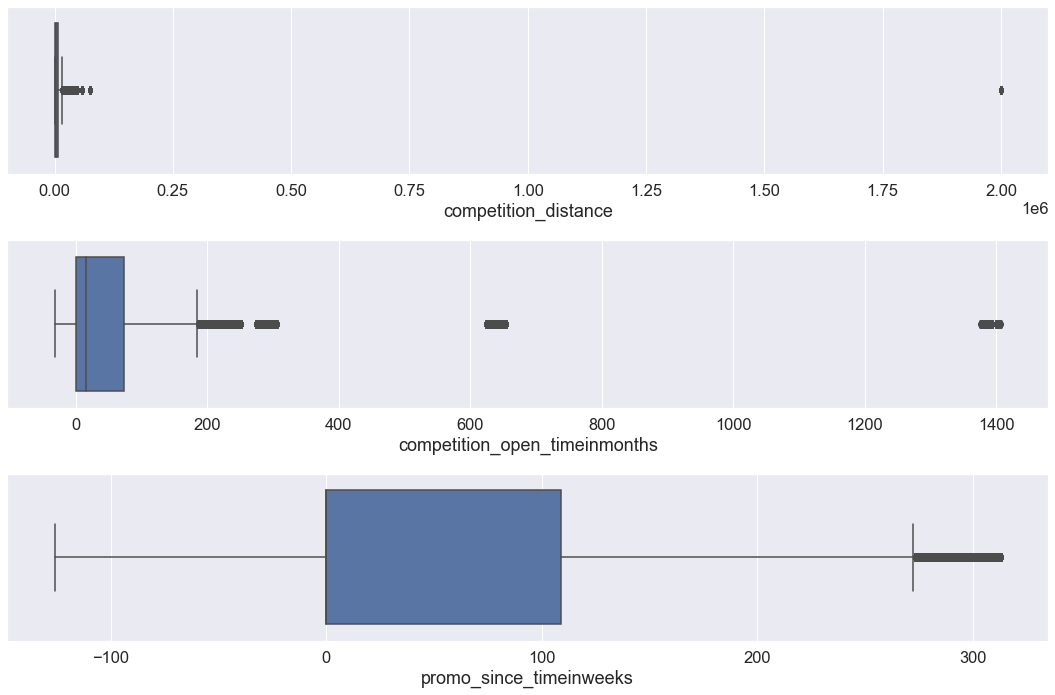

In [43]:
# checking outliers

# competition_distance
plt.subplot(3,1,1)
sns.boxplot(data=df5, x=df5['competition_distance']);

# competition_open_timeinmonths
plt.subplot(3,1,2)
sns.boxplot(data=df5, x=df5['competition_open_timeinmonths']);

# promo_since_timeinweeks
plt.subplot(3,1,3)
sns.boxplot(data=df5, x=df5['promo_since_timeinweeks']);

plt.tight_layout()

In [44]:
# rescaling

rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('../parameters/rescaling_competition_distance.pkl', 'wb'))

# competition_open_timeinmonths
df5['competition_open_timeinmonths'] = rs.fit_transform(df5[['competition_open_timeinmonths']].values)
pickle.dump(rs, open('../parameters/rescaling_competition_open_timeinmonths.pkl', 'wb'))

# promo_since_timeinweeks
df5['promo_since_timeinweeks'] = mms.fit_transform(df5[['promo_since_timeinweeks']].values)
pickle.dump(rs, open('../parameters/rescaling_promo_since_timeinweeks.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('../parameters/rescaling_year.pkl', 'wb'))


df5[['competition_distance', 'competition_open_timeinmonths', 'promo_since_timeinweeks']].head()

competition_distance  competition_open_timeinmonths  \
0                 -0.17                           0.92   
1                 -0.28                           1.05   
2                  1.90                           1.20   
3                 -0.28                           0.74   
4                  4.45                          -0.16   

   promo_since_timeinweeks  
0                     0.29  
1                     0.92  
2                     0.80  
3                     0.29  
4                     0.29

## Transforming

### Encoding

In [45]:
df52 = df5.copy()

cat_df5 = df5.select_dtypes(exclude=['int64','float64','datetime64[ns]'])
cat_df5.head()

state_holiday store_type assortment year_week
0   regular day          c      basic   2015-30
1   regular day          a      basic   2015-30
2   regular day          a      basic   2015-30
3   regular day          c   extended   2015-30
4   regular day          a      basic   2015-30

In [46]:
# state_holiday - one hot enconding (each holiday becomes a column)
df52 = pd.get_dummies(df52, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - label enconding (each type becomes a value in a range)
le = preprocessing.LabelEncoder()
df52['store_type'] = le.fit_transform(df52['store_type'])
pickle.dump(le, open('../parameters/encoding_store_type.pkl', 'wb'))

# assortment - ordinal enconding (each assortment becomes a value in a hierarchy)
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df52['assortment'] = df52['assortment'].map(assortment_dict)

df52.head()

store  day_of_week       date  sales  promo  school_holiday  store_type  \
0      1            5 2015-07-31   5263      1               1           2   
1      2            5 2015-07-31   6064      1               1           0   
2      3            5 2015-07-31   8314      1               1           0   
3      4            5 2015-07-31  13995      1               1           2   
4      5            5 2015-07-31   4822      1               1           0   

   assortment  competition_distance  competition_open_since_month  ...  \
0           1                 -0.17                             9  ...   
1           1                 -0.28                            11  ...   
2           1                  1.90                            12  ...   
3           3                 -0.28                             9  ...   
4           1                  4.45                             4  ...   

   week_of_year  year_week  competition_open_since  \
0            31    2015-30              2008-09-01   
1            31    2015-30              2007-11-01   
2            31    2015-30              2006-12-01   
3            31    2015-30              2009-09-01   
4            31    2015-30              2015-04-01   

   competition_open_timeinmonths  promo_since  promo_since_timeinweeks  \
0                           0.92   2015-07-27                     0.29   
1                           1.05   2010-03-22                     0.92   
2                           1.20   2011-03-28                     0.80   
3                           0.74   2015-07-27                     0.29   
4                          -0.16   2015-07-27                     0.29   

   state_holiday_Christmas  state_holiday_Easter holiday  \
0                        0                             0   
1                        0                             0   
2                        0                             0   
3                        0                             0   
4                        0                             0   

   state_holiday_Public holiday state_holiday_regular day  
0                             0                         1  
1                             0                         1  
2                             0                         1  
3                             0                         1  
4                             0                         1  

[5 rows x 28 columns]

### Response Variable Transformation

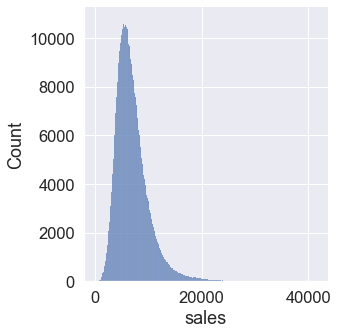

In [47]:
sns.displot(df52['sales']);

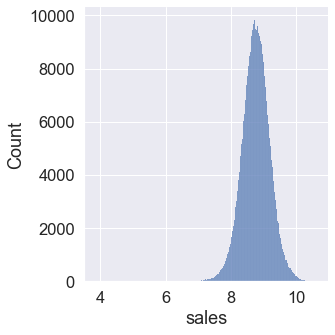

In [48]:
df52['sales'] = np.log1p(df52['sales'])
sns.displot(df52['sales']);

### Nature Transformation

In [49]:
# month
df52['month_sin'] = df52['month'].apply(lambda x: np.sin(x*(2*np.pi/12))) 
df52['month_cos'] = df52['month'].apply(lambda x: np.cos(x*(2*np.pi/12))) 

# week_of_year
df52['week_of_year_sin'] = df52['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52))) 
df52['week_of_year_cos'] = df52['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52))) 

# day
df52['day_sin'] = df52['day'].apply(lambda x: np.sin(x*(2*np.pi/30))) 
df52['day_cos'] = df52['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# day_of_week
df52['day_of_week_sin'] = df52['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7))) 
df52['day_of_week_cos'] = df52['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))



df52.head()

store  day_of_week       date  sales  promo  school_holiday  store_type  \
0      1            5 2015-07-31   8.57      1               1           2   
1      2            5 2015-07-31   8.71      1               1           0   
2      3            5 2015-07-31   9.03      1               1           0   
3      4            5 2015-07-31   9.55      1               1           2   
4      5            5 2015-07-31   8.48      1               1           0   

   assortment  competition_distance  competition_open_since_month  ...  \
0           1                 -0.17                             9  ...   
1           1                 -0.28                            11  ...   
2           1                  1.90                            12  ...   
3           3                 -0.28                             9  ...   
4           1                  4.45                             4  ...   

   state_holiday_Public holiday  state_holiday_regular day  month_sin  \
0                             0                          1      -0.50   
1                             0                          1      -0.50   
2                             0                          1      -0.50   
3                             0                          1      -0.50   
4                             0                          1      -0.50   

   month_cos  week_of_year_sin  week_of_year_cos  day_sin  day_cos  \
0      -0.87             -0.57             -0.82     0.21     0.98   
1      -0.87             -0.57             -0.82     0.21     0.98   
2      -0.87             -0.57             -0.82     0.21     0.98   
3      -0.87             -0.57             -0.82     0.21     0.98   
4      -0.87             -0.57             -0.82     0.21     0.98   

   day_of_week_sin day_of_week_cos  
0            -0.97           -0.22  
1            -0.97           -0.22  
2            -0.97           -0.22  
3            -0.97           -0.22  
4            -0.97           -0.22  

[5 rows x 36 columns]

# FEATURE SELECTION

In [50]:
df6 = df52.copy()
df6.head()

store  day_of_week       date  sales  promo  school_holiday  store_type  \
0      1            5 2015-07-31   8.57      1               1           2   
1      2            5 2015-07-31   8.71      1               1           0   
2      3            5 2015-07-31   9.03      1               1           0   
3      4            5 2015-07-31   9.55      1               1           2   
4      5            5 2015-07-31   8.48      1               1           0   

   assortment  competition_distance  competition_open_since_month  ...  \
0           1                 -0.17                             9  ...   
1           1                 -0.28                            11  ...   
2           1                  1.90                            12  ...   
3           3                 -0.28                             9  ...   
4           1                  4.45                             4  ...   

   state_holiday_Public holiday  state_holiday_regular day  month_sin  \
0                             0                          1      -0.50   
1                             0                          1      -0.50   
2                             0                          1      -0.50   
3                             0                          1      -0.50   
4                             0                          1      -0.50   

   month_cos  week_of_year_sin  week_of_year_cos  day_sin  day_cos  \
0      -0.87             -0.57             -0.82     0.21     0.98   
1      -0.87             -0.57             -0.82     0.21     0.98   
2      -0.87             -0.57             -0.82     0.21     0.98   
3      -0.87             -0.57             -0.82     0.21     0.98   
4      -0.87             -0.57             -0.82     0.21     0.98   

   day_of_week_sin day_of_week_cos  
0            -0.97           -0.22  
1            -0.97           -0.22  
2            -0.97           -0.22  
3            -0.97           -0.22  
4            -0.97           -0.22  

[5 rows x 36 columns]

## Training and Test dataset

In [51]:
# deleting columns that derived other features
dropcols = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_open_since', 'year_week']
df6 = df6.drop(dropcols, axis=1)
df6.shape

(844338, 29)

In [52]:
# Checking 'date' intervals
print(df6[['store', 'date']].groupby('store').min().reset_index()['date'][0], '-> First date')
print(df6[['store', 'date']].groupby('store').max().reset_index()['date'][0], '-> Last date', )
print(df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7), '-> Six weeks before last date')

2013-01-02 00:00:00 -> First date
2015-07-31 00:00:00 -> Last date
2015-06-19 00:00:00 -> Six weeks before last date


In [53]:
# Training Dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# Test Dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))
print()
print('Test Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## Boruta as Feature Selection

In [89]:
# training and test datset for Boruta
X_train_blist = X_train.drop(['date', 'sales'], axis=1).values # array
Y_train_blist = Y_train.values.ravel() # array

# defining Radom Forest Regressor
rf = RandomForestRegressor(n_jobs=-1) # pararel processing

# defining Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_blist, Y_train_blist)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


In [54]:
cols_selected_blist = boruta.support_.tolist() # list of features boruta selected in boolean format
X_train_FS = X_train.drop(['date', 'sales'], axis=1) # deleting cols from X_train to read next step
X_train_FS.head()

# Features Selected from Boruta
cols_selected_boruta = X_train_FS.iloc[:, cols_selected_blist].columns.to_list() # list of columns boruta selected

# Features not Selected from Boruta
cols_notselected_boruta = list(np.setdiff1d(X_train_FS.columns, cols_selected_boruta)) # list of columns boruta did not select

NameError: name 'boruta' is not defined

## Manual Feature Selection

In [91]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_open_timeinmonths',
 'promo_since_timeinweeks',
 'month_cos',
 'week_of_year_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [54]:
# Features Selected from Boruta
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_open_timeinmonths',
 'promo_since_timeinweeks',
 'month_sin', # added manually
 'month_cos',
 'week_of_year_sin', # added manually
 'week_of_year_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# features to add
features_added = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(features_added)

cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_open_timeinmonths',
 'promo_since_timeinweeks',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'date',
 'sales']

# MACHINE LEARNING

In [56]:
# X_train only with columns selected by boruta // X_train = df6[df6['date'] < '2015-06-19']
x_train_colsb = X_train[cols_selected_boruta] 

# X_test only with columns selected by boruta // X_test = df6[df6['date'] >= '2015-06-19']
x_test_colsb = X_test[cols_selected_boruta] 

# X_train with boruta columns + dates + sales // time series data preparation
x_training_colsfull = X_train[cols_selected_boruta_full]

## Average Model

In [57]:
aux1 = x_test_colsb.copy() # X_test with columns selected with boruta
aux1['sales'] = Y_test.copy() # Y_test = X_test['sales']
aux1.head() # kind of 'original' dataset but only with selected columns with boruta

# creating prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'mean_prediction'}) # calculating mean sales by store
aux3 = pd.merge(aux1, aux2, how='left', on='store') # merging with aux1 dataframe to add 'mean_prediction' to the dataset

# ŷ -> predicted value
yhat_baseline = aux3['mean_prediction'] 

# performance analysis // ml_error(model_name, y, yhat):
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline)) # function created // transformation to exponential needed because it was used 'log' in 'sales' on 5.3.2 Response Variable Transformation
baseline_result

Model Name     MAE  MAPE    RSME
0  Average Model 1354.80  0.21 1835.14

## Linear Regression Model

In [58]:
# model
lr = LinearRegression().fit(x_train_colsb, Y_train)

# creating prediction
yhat_lr = lr.predict(x_test_colsb) # ŷ -> predicted value

# performance // ml_error(model_name, y, yhat):
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr)) # ml_error(model_name, y, yhat) // y: real values, yhat: predicted values
lr_result

Model Name     MAE  MAPE    RSME
0  Linear Regression 1863.63  0.29 2673.14

## Linear Regression Regularized Model - Lasso

In [59]:
# model
lrr = Lasso(alpha=0.01).fit(x_train_colsb, Y_train)

# creating prediction
yhat_lrr = lrr.predict(x_test_colsb) # ŷ -> predicted value


# performance // ml_error(model_name, y, yhat):
lrr_result = ml_error('Linear Regression Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

Model Name     MAE  MAPE    RSME
0  Linear Regression Lasso 1889.98  0.29 2745.97

## Random Forest Regressor

In [60]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train_colsb, Y_train)

# creating prediction
yhat_rf = rf.predict(x_test_colsb) # ŷ -> predicted value


# performance // ml_error(model_name, y, yhat):
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

Model Name    MAE  MAPE    RSME
0  Random Forest Regressor 678.96  0.10 1009.80

## XGBoost

In [61]:
# model
xgbm = xgb.XGBRegressor(objective='reg:squarederror',
                        n_estimators=1000, 
                        eta=0.01, 
                        max_depth=10,
                        subsample=0.7,
                        colsample_bytree=0.9).fit(x_train_colsb, Y_train)

# creating prediction
yhat_xgb = xgbm.predict(x_test_colsb) # ŷ -> predicted value
yhat_xgb

# performance // ml_error(model_name, y, yhat):
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

Model Name    MAE  MAPE   RSME
0  XGBoost Regressor 659.51  0.10 956.64

## Models Performance Comparison

### Single Performance

In [62]:
comparison_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
comparison_result.sort_values('RSME', ascending=True)

Model Name     MAE  MAPE    RSME
0        XGBoost Regressor  659.51  0.10  956.64
0  Random Forest Regressor  678.96  0.10 1009.80
0            Average Model 1354.80  0.21 1835.14
0        Linear Regression 1863.63  0.29 2673.14
0  Linear Regression Lasso 1889.98  0.29 2745.97

### Real Performance - Cross Validation

In [63]:
# 'cross_validation' formula
# cross_validation(x_training_colsfull, kfold, model_name, model, verbose=True)

In [64]:
# Linear Regression
lr_result_cv = cross_validation(x_training_colsfull, 5, 'Linear Regression', lr, verbose=True)
lr_result_cv


 Kfold number: 5

 Kfold number: 4

 Kfold number: 3

 Kfold number: 2

 Kfold number: 1


Model Name         MAE Mean CV  MAPE Mean CV        RMSE Mean CV
0  Linear Regression  2083.17 +/- 294.98  0.3 +/- 0.02  2958.87 +/- 466.72

In [65]:
# Linear Regularized Model - Lasso
lrr_result_cv = cross_validation(x_training_colsfull, 5, 'Lasso', lrr, verbose=True)
lrr_result_cv


 Kfold number: 5

 Kfold number: 4

 Kfold number: 3

 Kfold number: 2

 Kfold number: 1


Model Name         MAE Mean CV  MAPE Mean CV        RMSE Mean CV
0      Lasso  2063.95 +/- 292.89  0.3 +/- 0.01  2941.37 +/- 452.31

In [66]:
# Random Forest
rf_result_cv = cross_validation(x_training_colsfull, 5, 'Radom Forest Regressor', rf, verbose=True)
rf_result_cv


 Kfold number: 5

 Kfold number: 4

 Kfold number: 3

 Kfold number: 2

 Kfold number: 1


Model Name         MAE Mean CV  MAPE Mean CV  \
0  Radom Forest Regressor  2063.95 +/- 292.89  0.3 +/- 0.01   

         RMSE Mean CV  
0  2941.37 +/- 452.31

In [67]:
# XGBoost
xgb_result_cv = cross_validation(x_training_colsfull, 5, 'XGBoost Regressor', xgbm, verbose=True)
xgb_result_cv


 Kfold number: 5

 Kfold number: 4

 Kfold number: 3

 Kfold number: 2

 Kfold number: 1


Model Name         MAE Mean CV  MAPE Mean CV        RMSE Mean CV
0  XGBoost Regressor  2063.95 +/- 292.89  0.3 +/- 0.01  2941.37 +/- 452.31

In [68]:
# Comparison Table - Cross Validation
comparison_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
comparison_result_cv

Model Name         MAE Mean CV  MAPE Mean CV  \
0       Linear Regression  2083.17 +/- 294.98  0.3 +/- 0.02   
0                   Lasso  2063.95 +/- 292.89  0.3 +/- 0.01   
0  Radom Forest Regressor  2063.95 +/- 292.89  0.3 +/- 0.01   
0       XGBoost Regressor  2063.95 +/- 292.89  0.3 +/- 0.01   

         RMSE Mean CV  
0  2958.87 +/- 466.72  
0  2941.37 +/- 452.31  
0  2941.37 +/- 452.31  
0  2941.37 +/- 452.31

In [69]:
# Comparision Table - Single Performance
comparison_result

Model Name     MAE  MAPE    RSME
0            Average Model 1354.80  0.21 1835.14
0        Linear Regression 1863.63  0.29 2673.14
0  Linear Regression Lasso 1889.98  0.29 2745.97
0  Random Forest Regressor  678.96  0.10 1009.80
0        XGBoost Regressor  659.51  0.10  956.64

In [71]:
# saving models

# linear regression
pickle.dump(lr_result_cv, open('C:/Users/maria/Documents/repositories/P002_Sales_Predictions_Drugstore/model/lr_result_cv.pkl', 'wb'))

# lasso
pickle.dump(lrr_result_cv, open('C:/Users/maria/Documents/repositories/P002_Sales_Predictions_Drugstore/model/lrr_result_cv.pkl', 'wb'))

# random forest
pickle.dump(rf_result_cv, open('C:/Users/maria/Documents/repositories/P002_Sales_Predictions_Drugstore/model/rf_result_cv.pkl', 'wb'))

# xgboost
pickle.dump(xgb_result_cv, open('C:/Users/maria/Documents/repositories/P002_Sales_Predictions_Drugstore/model/xgb_result_cv.pkl', 'wb'))

# # loading models
# pickle.load(open('C:/Users/maria/Documents/repositories/P002_Sales_Predictions_Drugstore/model/lr_result_cv.pkl', 'rb'))
# pickle.load(open('C:/Users/maria/Documents/repositories/P002_Sales_Predictions_Drugstore/model/lrr_result_cv.pkl', 'rb'))
# pickle.load(open('C:/Users/maria/Documents/repositories/P002_Sales_Predictions_Drugstore/model/rf_result_cv.pkl', 'rb'))
# pickle.load(open('C:/Users/maria/Documents/repositories/P002_Sales_Predictions_Drugstore/model/xgb_result_cv.pkl', 'rb'))

# HYPER PARAMETER FINE TUNING

## Random Search

In [74]:
# param_dict = {'n_estimators': [250, 500, 1000, 1500, 2500, 3000],
#               'eta': [0.01, 0.03],
#               'max_depth': [3, 6, 9],
#               'subsample': [0.1, 0.5, 0.7],
#               'colsample_bytree': [0.3, 0.5, 0.8, 1],
#               'min_child_weight': [1, 3, 8, 15]}

# max_eval = 2

In [75]:
# final_result = pd.DataFrame()
# hyperparam_list = []

# for i in range(max_eval):
    
#     # choose random param values
#     hp = {k: random.sample(v, 1)[0] for k, v in param_dict.items()}
    
#     # print selected values
#     print(hp)
    
#     #store in list
#     hyperparam_list.append(hp.copy())

#     # model
#     xgbm = xgb.XGBRegressor(objective='reg:squarederror',
#                             n_estimators=hp['n_estimators'], 
#                             eta=hp['eta'], 
#                             max_depth=hp['max_depth'],
#                             subsample=hp['subsample'],
#                             colsample_bytree=hp['colsample_bytree'],
#                             min_child_weight=hp['min_child_weight'])

    
#     # performance
#     xgb_result = cross_validation(x_training_colsfull, 2, 'XGBoost Regressor', xgbm, verbose=True)
#     final_result = pd.concat([final_result, xgb_result])
    
    
# display(final_result)
# print(hyperparam_list)

{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.5, 'min_child_weight': 15}

 Kfold number: 2

 Kfold number: 1
{'n_estimators': 500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.8, 'min_child_weight': 1}

 Kfold number: 2

 Kfold number: 1


Model Name        MAE Mean CV  MAPE Mean CV       RMSE Mean CV
0  XGBoost Regressor  2021.41 +/- 40.41  0.29 +/- 0.0  2915.69 +/- 68.83
0  XGBoost Regressor  2021.41 +/- 40.41  0.29 +/- 0.0  2915.69 +/- 68.83

[{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.5, 'min_child_weight': 15}, {'n_estimators': 500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.8, 'min_child_weight': 1}]


In [76]:
hyperparam_list

[{'n_estimators': 2500,
  'eta': 0.01,
  'max_depth': 3,
  'subsample': 0.1,
  'colsample_bytree': 0.5,
  'min_child_weight': 15},
 {'n_estimators': 500,
  'eta': 0.01,
  'max_depth': 3,
  'subsample': 0.1,
  'colsample_bytree': 0.8,
  'min_child_weight': 1}]

## Final Model - XGBoost

In [72]:
tuned_param_dict = {'n_estimators': 1000,
                      'eta': 0.01,
                      'max_depth': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.9,
                      'min_child_weight': 8}

In [73]:
# model
xgbm_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=tuned_param_dict['n_estimators'], 
                                eta=tuned_param_dict['eta'], 
                                max_depth=tuned_param_dict['max_depth'],
                                subsample=tuned_param_dict['subsample'],
                                colsample_bytree=tuned_param_dict['colsample_bytree'],
                                min_child_weight=tuned_param_dict['min_child_weight']).fit(x_train_colsb, Y_train)

# prediction
yhat_xgb_tuned = xgbm_tuned.predict(x_test_colsb)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned ))
xgb_result_tuned

Model Name    MAE  MAPE   RSME
0  XGBoost Regressor 633.05  0.09 922.14

In [74]:
# saving XGB model
pickle.dump(xgbm_tuned, open('C:/Users/maria/Documents/repositories/P002_Sales_Predictions_Drugstore/model/model_xgb_tuned.pkl', 'wb'))

## Final Model - Random Forest

In [ ]:
# model
rf_tuned = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train_colsb, Y_train)

# creating prediction
yhat_rf_tuned = rf_tuned.predict(x_test_colsb) # ŷ -> predicted value


# performance // ml_error(model_name, y, yhat):
rf_result_tuned = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf_tuned))
rf_result_tuned

In [80]:
# saving RF model
pickle.dump(rf_result_tuned, open('C:/Users/Mariana/Documents/repositories/P002_Sales_Predictions_Drugstore/model/model_rf_tuned.pkl', 'wb'))

# ERROR INTERPRETATION

In [75]:
df9 = X_test[cols_selected_boruta_full].copy()

# rescaling
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

display(df9.head())

store  promo  store_type  assortment  competition_distance  \
0      1      1           2           1                 -0.17   
1      2      1           0           1                 -0.28   
2      3      1           0           1                  1.90   
3      4      1           2           3                 -0.28   
4      5      1           0           1                  4.45   

   competition_open_since_month  competition_open_since_year  promo2  \
0                             9                         2008       0   
1                            11                         2007       1   
2                            12                         2006       1   
3                             9                         2009       0   
4                             4                         2015       0   

   promo2_since_week  promo2_since_year  ...  month_cos  week_of_year_sin  \
0                 31               2015  ...      -0.87             -0.57   
1                 13               2010  ...      -0.87             -0.57   
2                 14               2011  ...      -0.87             -0.57   
3                 31               2015  ...      -0.87             -0.57   
4                 31               2015  ...      -0.87             -0.57   

   week_of_year_cos  day_sin  day_cos  day_of_week_sin  day_of_week_cos  \
0             -0.82     0.21     0.98            -0.97            -0.22   
1             -0.82     0.21     0.98            -0.97            -0.22   
2             -0.82     0.21     0.98            -0.97            -0.22   
3             -0.82     0.21     0.98            -0.97            -0.22   
4             -0.82     0.21     0.98            -0.97            -0.22   

        date    sales  predictions  
0 2015-07-31  5263.00      5395.64  
1 2015-07-31  6064.00      5669.12  
2 2015-07-31  8314.00      8833.86  
3 2015-07-31 13995.00     11455.97  
4 2015-07-31  4822.00      6385.48  

[5 rows x 23 columns]

## Business Performance

In [76]:
# sum of predictions by store
df91 = df9[['store', 'sales', 'predictions']].groupby('store').sum().reset_index()
print('Sum of predictions per store')
display(df91.head(5))

# MAE and MAPE per store
df91_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df91_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# merging to sum of predictions
df91_aux3 = pd.merge(df91_aux1, df91_aux2, how='inner', on='store')
df91aux = pd.merge(df91, df91_aux3, how='inner', on='store')

# scenarios
df91aux['worst_scenario'] = df91aux['predictions'] - df91aux['MAE']
df91aux['best_scenario'] = df91aux['predictions'] + df91aux['MAE']

# reordering columns
df91aux = df91aux[['store', 'sales', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
print('Scenarios and predictions per store')
df91aux.head()

# saving resumed dataframe with predictions and scenarios
#df9.to_csv('../data/processed/sales_prediction_fulldata.csv')

Sum of predictions per store


store     sales  predictions
0      1 162320.00    161589.67
1      2 182936.00    174889.31
2      3 254190.00    254300.42
3      4 369378.00    341202.50
4      5 166905.00    175589.00

Scenarios and predictions per store


store     sales  predictions  worst_scenario  best_scenario    MAE  MAPE
0      1 162320.00    161589.67       161339.00      161840.34 250.67  0.06
1      2 182936.00    174889.31       174515.49      175263.13 373.82  0.08
2      3 254190.00    254300.42       253794.99      254805.85 505.43  0.07
3      4 369378.00    341202.50       340310.44      342094.56 892.06  0.09
4      5 166905.00    175589.00       175126.66      176051.34 462.34  0.11

## Scenarios Performance

In [77]:
df92 = df91aux[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scneario', 0: 'Values'})
df92['Values'] = df92['Values'].map('${:,.2f}'.format)
df92.head()

Scneario           Values
0     predictions  $282,897,056.00
1  worst_scenario  $282,187,095.44
2   best_scenario  $283,607,052.80

## Machine Learning Performance

In [78]:
df9['error'] = df9['predictions'] - df9['sales']
df9['error_rate'] = df9['predictions'] / df9['sales'] - 1
df9.head(10)

store  promo  store_type  assortment  competition_distance  \
0      1      1           2           1                 -0.17   
1      2      1           0           1                 -0.28   
2      3      1           0           1                  1.90   
3      4      1           2           3                 -0.28   
4      5      1           0           1                  4.45   
5      6      1           0           1                 -0.33   
6      7      1           0           3                  3.50   
7      8      1           0           1                  0.84   
8      9      1           0           3                 -0.05   
9     10      1           0           1                  0.13   

   competition_open_since_month  competition_open_since_year  promo2  \
0                             9                         2008       0   
1                            11                         2007       1   
2                            12                         2006       1   
3                             9                         2009       0   
4                             4                         2015       0   
5                            12                         2013       0   
6                             4                         2013       0   
7                            10                         2014       0   
8                             8                         2000       0   
9                             9                         2009       0   

   promo2_since_week  promo2_since_year  ...  week_of_year_cos  day_sin  \
0                 31               2015  ...             -0.82     0.21   
1                 13               2010  ...             -0.82     0.21   
2                 14               2011  ...             -0.82     0.21   
3                 31               2015  ...             -0.82     0.21   
4                 31               2015  ...             -0.82     0.21   
5                 31               2015  ...             -0.82     0.21   
6                 31               2015  ...             -0.82     0.21   
7                 31               2015  ...             -0.82     0.21   
8                 31               2015  ...             -0.82     0.21   
9                 31               2015  ...             -0.82     0.21   

   day_cos  day_of_week_sin  day_of_week_cos       date    sales  predictions  \
0     0.98            -0.97            -0.22 2015-07-31  5263.00      5395.64   
1     0.98            -0.97            -0.22 2015-07-31  6064.00      5669.12   
2     0.98            -0.97            -0.22 2015-07-31  8314.00      8833.86   
3     0.98            -0.97            -0.22 2015-07-31 13995.00     11455.97   
4     0.98            -0.97            -0.22 2015-07-31  4822.00      6385.48   
5     0.98            -0.97            -0.22 2015-07-31  5651.00      5991.25   
6     0.98            -0.97            -0.22 2015-07-31 15344.00     12559.11   
7     0.98            -0.97            -0.22 2015-07-31  8492.00      6677.20   
8     0.98            -0.97            -0.22 2015-07-31  8565.00      9169.97   
9     0.98            -0.97            -0.22 2015-07-31  7185.00      6675.17   

     error  error_rate  
0   132.64        0.03  
1  -394.88       -0.07  
2   519.86        0.06  
3 -2539.03       -0.18  
4  1563.48        0.32  
5   340.25        0.06  
6 -2784.89       -0.18  
7 -1814.80       -0.21  
8   604.97        0.07  
9  -509.83       -0.07  

[10 rows x 25 columns]

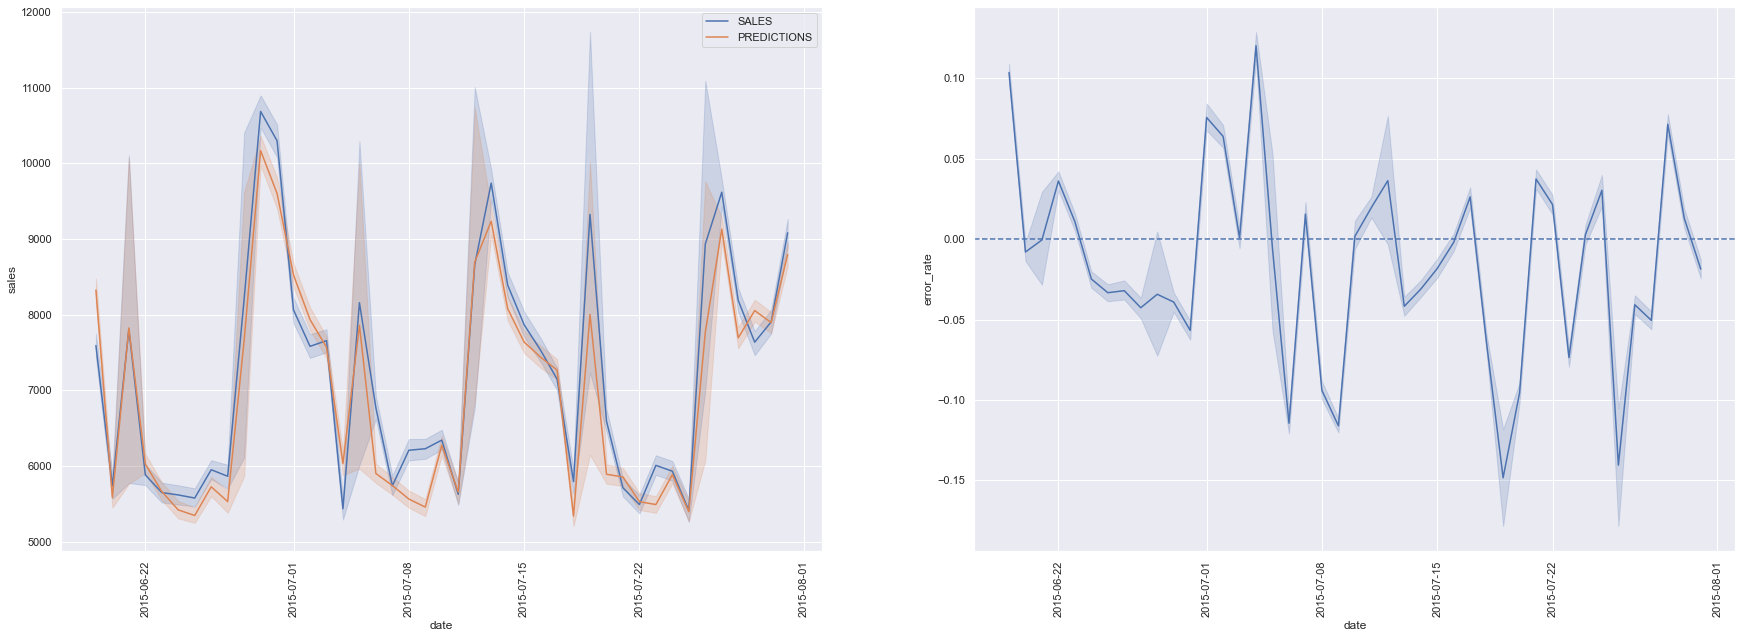

In [79]:
sns.set(rc={'figure.figsize':(30, 10)})

# sales and prediction comparison
plt.subplot(1,2,1)
sns.lineplot(data=df9, x='date', y='sales', label='SALES')
sns.lineplot(data=df9, x='date', y='predictions', label='PREDICTIONS')
plt.xticks(rotation=90);

# error rate
plt.subplot(1,2,2)
sns.lineplot(data=df9, x='date', y='error_rate')
plt.axhline(0, linestyle='--')
plt.xticks(rotation=90);

personal_settings()

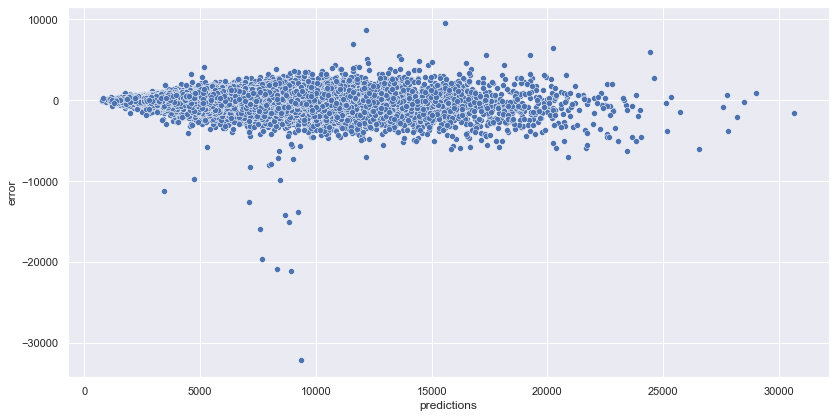

In [80]:
sns.set(rc={'figure.figsize':(30, 15)})

# predictions by error distribution 
plt.subplot(2,2,3)
sns.scatterplot(data=df9, x='predictions', y='error')
personal_settings()

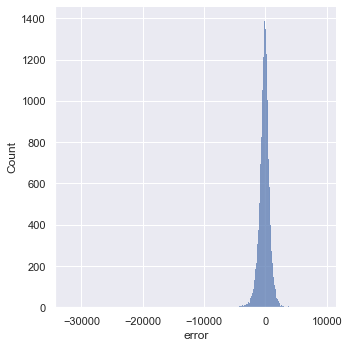

In [81]:
sns.set(rc={'figure.figsize':(30, 15)})

# error distribution
#plt.subplot(2,2,4)
sns.displot(data=df9, x='error')
personal_settings()

## Saving Results to .CSV

In [82]:
# saving full dataframe with predictions and error rates
df9.to_csv('../data/processed/sales_prediction_fulldata.csv')

#df9.head()

In [83]:
# saving resumed dataframe with predictions per store and scenarios
df91aux.to_csv('../data/processed/sales_prediction_resumed.csv')

#df91aux.head()

# MODEL DEPLOY

## Rossmann Class

In [84]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann(object):
    def __init__(self):
        self.home_path = 'C:/Users/Mariana/Documents/repositories/P002_Sales_Predictions_Drugstore/'
        self.rescaling_competition_distance          = pickle.load(open(self.home_path + 'parameters/rescaling_competition_distance.pkl', 'rb'))
        self.rescaling_competition_open_timeinmonths = pickle.load(open(self.home_path + 'parameters/rescaling_competition_open_timeinmonths.pkl', 'rb'))
        self.rescaling_promo_since_timeinweeks       = pickle.load(open(self.home_path + 'parameters/rescaling_promo_since_timeinweeks.pkl', 'rb'))
        self.rescaling_year                          = pickle.load(open(self.home_path + 'parameters/rescaling_year.pkl', 'rb'))
        self.encoding_store_type                     = pickle.load(open(self.home_path + 'parameters/encoding_store_type.pkl', 'rb'))

    def data_cleaning(self, df1):
        # === Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        # changing the name of the columns
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))

        # renaming dataset columns
        df1.columns = cols_new

        # === Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        # === Fill out NA

        # competition_distance
        df1['competition_distance'].max()  # #checking the maximum distance: 75860.0
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 2000000.0 if math.isnan(x) else (x))

        #  competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
                                                             else x['competition_open_since_month'], axis=1)

        #  competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                                            else x['competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                     7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        # filling Na with "0"
        df1['promo_interval'].fillna(0, inplace=True)

        # finding the month name given month number by mapping the "month_map" dictionary
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0
                                                                          else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                                          else 0, axis=1)

        # == Change Variables Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].to_numpy(dtype=int)
        # df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

        # df1['promo2_since_week'] = df1['promo2_since_week'].to_numpy(dtype=int)
        # df1['promo2_since_year'] = df1['promo2_since_year'].to_numpy(dtype=int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

        return df1

    def feature_engineering(self, df2):
        # === Feature Engineering

        # creating 'year' from 'date'
        df2['year'] = df2['date'].dt.year

        # creating 'month' from 'date'
        df2['month'] = df2['date'].dt.month

        # creating 'day' from 'date'
        df2['day'] = df2['date'].dt.day

        # creating 'week_of_year' from 'date'
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

        # creating 'year_week' from 'date'
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # creating 'competition_open_since' by combining 'competition_open_since_year and 'competition_open_since_month'
        df2['competition_open_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                              month=x['competition_open_since_month'],
                                                                              day=1), axis=1)

        # creating 'competition_open_timeinmonths' by calculating the difference between 'date' and 'competition_open_since':
        df2['competition_open_timeinmonths'] = ((df2['date'] - df2['competition_open_since']) / 30).apply(lambda x: x.days).astype('int64')

        # creating 'promo_since' by combining 'promo2_since_year' and 'promo2_since_week'
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)  # string type (year-week, ex: 2015-31)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))  # date type (yyyy-mm-dd)

        # creating 'promo_since_timeinweeks' by calculating the difference between 'date' and 'promo_since':
        df2['promo_since_timeinweeks'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

        # changing 'assortment' attribute by given classification
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a'
                                                         else 'extra' if x == 'b'
                                                         else 'extended')

        # changing 'sate_holiday' attribute by given classification
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'Public_holiday' if x == 'a'
                                                               else 'Easter_holiday' if x == 'b'
                                                               else 'Christmas' if x == 'c'
                                                               else 'regular_day')

        # === Variable Filtering
        df2 = df2[(df2['open'] != 0)]
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2

    def data_preparation(self, df5):
        # ===  Rescaling

        # competition_distance
        df5['competition_distance'] = self.rescaling_competition_distance.transform(df5[['competition_distance']].values)

        # competition_open_timeinmonths
        df5['competition_open_timeinmonths'] = self.rescaling_competition_open_timeinmonths.transform(df5[['competition_open_timeinmonths']].values)

        # promo_since_timeinweeks
        df5['promo_since_timeinweeks'] = self.rescaling_promo_since_timeinweeks.transform(df5[['promo_since_timeinweeks']].values)

        # year
        df5['year'] = self.rescaling_year.transform(df5[['year']].values)

        # === Encoding

        # state_holiday - one hot enconding (each holiday becomes a column)
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - label enconding (each type becomes a value in a range)
        df5['store_type'] = self.encoding_store_type.fit_transform(df5['store_type'])

        # assortment - ordinal enconding (each assortment becomes a value in a hierarchy)
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        # === Nature Transformation

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year',
                         'competition_open_timeinmonths', 'promo_since_timeinweeks', 'month_sin', 'month_cos', 'week_of_year_sin',
                         'week_of_year_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos']

        return df5[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)

        # joining prediction into the original data
        original_data['predictions'] = np.expm1(pred)

        return original_data.to_json(orient='records', date_format='iso')

## API Handler

In [85]:
import pandas           as pd
import pickle
from flask              import Flask, request, Response
from rossmann.Rossmann  import Rossmann # from folder.file import class

# loading model
model = pickle.load(open('C:/Users/Mariana/Documents/repositories/P002_Sales_Predictions_Drugstore/model/model_xgb_tuned.pkl', 'rb')) # usar endereço completo se erro

# initalizing API
app = Flask(__name__)

@app.route("/rossmann/prediction", methods=['POST']) #endpoint
def rossmann_prediction():
    test_json = request.get_json()

    if test_json:  # if not empty

        if isinstance(test_json, dict):  # if unique json
            test_df = pd.DataFrame(test_json, index=[0])
        else:  # if multiple jsons
            test_df = pd.DataFrame(test_json, columns=test_json[0].keys())

        # instantiate Rossmann Class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning(test_df)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_df, df3)

        return df_response

    else:  # if empty
        return Response('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    app.run('192.168.0.7', port=5000, debug=True)
    #app.run('127.0.0.1', port=5000, debug=True)
    #app.run('0.0.0.0', debug=True)

ModuleNotFoundError: No module named 'rossmann'

## API Tester

In [96]:
# loading test dataset
df10 = pd.read_csv('../data/raw/test.csv', low_memory=False)

# merging datasets
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choosing one store for prediction
#df_test = df_test[df_test['Store']==22]
df_test = df_test[df_test['Store'].isin([25,10])]

# deleting closed days
df_test = df_test[df_test['Open']!=0]
df_test = df_test[~df_test.isnull()]
df_test = df_test.drop('Id', axis=1)

# converting df to json
data = json.dumps(df_test.to_dict(orient='records'))

In [97]:
# API Call
#url = 'http://192.168.0.16:5000/rossmann/prediction' # endpoint
url = 'https://p002-sales-predictions.herokuapp.com/rossmann/prediction'

header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header) # response
print('Status Code {}'.format(r.status_code))

Status Code 200


In [98]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.head()

store  day_of_week                      date  open  promo state_holiday  \
0     10            4  2015-09-17T00:00:00.000Z  1.00      1   regular_day   
1     25            4  2015-09-17T00:00:00.000Z  1.00      1   regular_day   
2     10            3  2015-09-16T00:00:00.000Z  1.00      1   regular_day   
3     25            3  2015-09-16T00:00:00.000Z  1.00      1   regular_day   
4     10            2  2015-09-15T00:00:00.000Z  1.00      1   regular_day   

   school_holiday store_type assortment  competition_distance  ...  year  \
0               0          a      basic               3160.00  ...  2015   
1               0          c      basic                430.00  ...  2015   
2               0          a      basic               3160.00  ...  2015   
3               0          c      basic                430.00  ...  2015   
4               0          a      basic               3160.00  ...  2015   

   month  day  week_of_year  year_week    competition_open_since  \
0      9   17            38    2015-37  2009-09-01T00:00:00.000Z   
1      9   17            38    2015-37  2003-04-01T00:00:00.000Z   
2      9   16            38    2015-37  2009-09-01T00:00:00.000Z   
3      9   16            38    2015-37  2003-04-01T00:00:00.000Z   
4      9   15            38    2015-37  2009-09-01T00:00:00.000Z   

  competition_open_timeinmonths               promo_since  \
0                            73  2015-09-14T00:00:00.000Z   
1                           151  2015-09-14T00:00:00.000Z   
2                            73  2015-09-14T00:00:00.000Z   
3                           151  2015-09-14T00:00:00.000Z   
4                            73  2015-09-14T00:00:00.000Z   

   promo_since_timeinweeks  predictions  
0                        0      5092.39  
1                        0     10436.48  
2                        0      5272.70  
3                        0     11329.25  
4                        0      6309.50  

[5 rows x 28 columns]

In [129]:
d2 = d1[['store', 'predictions']].groupby('store').sum().reset_index()
d2.head()

store  predictions
0     10    215920.54
1     25    414448.06

In [130]:
for i in range (len(d2)):
    print('Store numner {} will sell R${:,.2f} on the next 6 weeks'.format(d2.loc[i,'store'], d2.loc[i, 'predictions']))

Store numner 10 will sell R$215,920.54 on the next 6 weeks
Store numner 25 will sell R$414,448.06 on the next 6 weeks
